# **Final project , Liliia Yakunina**

##3)   Data analysis

###**Time Series Analysis:**

Analyze the trend of deal creation over time and its relationship with calls.

Study the distribution of deal closure times and the duration of the period from creation to closure.

**Campaign Effectiveness Analysis:**

Compare the effectiveness of different campaigns in terms of lead generation and conversion rate.

Evaluate the effectiveness of various marketing sources in generating quality leads.

**Sales Department Performance Analysis:**

Assess the performance of individual deal owners and marketing campaigns in terms of the number of processed deals, conversion rate, and total sales amount.

**Payments and Products Analysis:**

Examine the distribution of payment types and their impact on deal success.

Analyze the popularity and success of different products and education types.

###**Work Plan**

Before starting data analysis, key fields and approaches were identified for analyzing time series, campaign performance, sales, payments, products, and geography.

**Key Fields for Analysis and Merging**

**Deal ID** – unique deal identifier, used as the primary key.

**Manager Name** – deal owner, for evaluating sales team performance.

**Campaign Name** – links with marketing spend for campaign efficiency analysis.

**Lead Source** – for assessing marketing channel performance.

**Client ID & City** – for geographic analysis.

**German Level New**– combined with city to assess impact on deal success.

**Payment Type & Payment Status** – to analyze payment distribution and deal outcomes.

**Course Name & Education Type** – for product and course format analysis.

**Created Time & Closing Date** – for time series, deal duration, and trend analysis.

**Join Strategy**

**Calls & Deals:** connect Contact ID (Calls) with Client ID (Deals) via Contacts.

**Campaign Analysis**: merge Campaign Name (Deals) with Campaign (Spend) to account for marketing costs.

**Join Types**: primarily left join to retain all deals while adding supplementary data

In [1]:
from google.colab import files
uploaded = files.upload()

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import os

contacts = pd.read_parquet("Contacts_cleaned.parquet")
calls = pd.read_parquet("Calls_cleaned.parquet")
spend = pd.read_parquet("Spend_cleaned.parquet")
deals = pd.read_parquet("Deals_cleaned.parquet")


Saving Calls_cleaned.parquet to Calls_cleaned.parquet
Saving Contacts_cleaned.parquet to Contacts_cleaned.parquet
Saving Deals_cleaned.parquet to Deals_cleaned.parquet
Saving Spend_cleaned.parquet to Spend_cleaned.parquet


In [2]:
# Merge tables
calls_contacts = pd.merge(calls, contacts, on='Client ID', how='left')
deals_contacts = pd.merge(deals, contacts, on='Client ID', how='left')


In [3]:
# Convert data types of linking columns after merging
calls_contacts['Client ID'] = calls_contacts['Client ID'].astype('string')
deals_contacts['Client ID'] = deals_contacts['Client ID'].astype('string')


In [4]:
calls_contacts.head()

,Call ID,Call Start Time,Manager Name_x,Client ID,Call Type,Call Duration sec,Call Status,Outgoing Call Status,Scheduled in CRM,Call Status Grouped,Manager Name_y,Created Time,Modified Time
0,5805028000000805001,2023-06-30 08:43:00,John Doe,unknown,Inbound,171,Received,unknown,unknown,Successful,NaN,NaT,NaT
1,5805028000000768006,2023-06-30 08:46:00,John Doe,unknown,Outbound,28,Attended Dialled,Completed,not_Scheduled,Successful,NaN,NaT,NaT
2,5805028000000764027,2023-06-30 08:59:00,John Doe,unknown,Outbound,24,Attended Dialled,Completed,not_Scheduled,Successful,NaN,NaT,NaT
3,5805028000000787003,2023-06-30 09:20:00,John Doe,5805028000000645014,Outbound,6,Attended Dialled,Completed,not_Scheduled,Successful,Rachel White,2023-06-27 11:28:00,2023-12-22 13:34:00
4,5805028000000768019,2023-06-30 09:30:00,John Doe,5805028000000645014,Outbound,11,Attended Dialled,Completed,not_Scheduled,Successful,Rachel White,2023-06-27 11:28:00,2023-12-22 13:34:00


In [5]:
deals_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19847 entries, 0 to 19846
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Deal ID                    19847 non-null  string        
 1   Manager Name_x             19847 non-null  category      
 2   Closing Date               13904 non-null  datetime64[ns]
 3   Quality                    19847 non-null  category      
 4   Deal Stage                 19847 non-null  category      
 5   Lost Reason                19847 non-null  category      
 6   Landing Page               19847 non-null  string        
 7   Campaign Name              19847 non-null  string        
 8   SLA                        19847 non-null  int64         
 9   Ad Name                    19847 non-null  string        
 10  Ad Group                   19847 non-null  string        
 11  Lead Source                19847 non-null  category      
 12  Paym

##**3. Time Series Analysis**

**3.1. Examine the trend of deal creation over time and its relationship with calls**

To analyze trends in deal creation and their connection to calls, we can plot a line chart for both time series. This visualization will show the number of deals created and calls made over time, helping to identify patterns and potential correlations between them.

Saved: /content/png_projekt/deals_calls_over_time.png


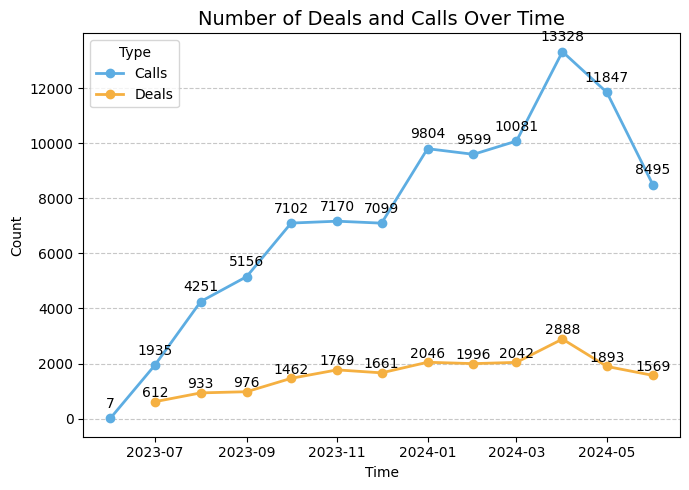

In [6]:
# Create columns for monthly periods
calls_contacts['Call Start Time Month'] = calls_contacts['Call Start Time'].dt.to_period('M')
deals_contacts['Created Time_x Month'] = deals_contacts['Created Time_x'].dt.to_period('M')

# Aggregate data by month for calls and deals
calls_by_month = calls_contacts.groupby('Call Start Time Month').size().reset_index(name='Calls Count')
deals_by_month = deals_contacts.groupby('Created Time_x Month').size().reset_index(name='Deals Count')

# Fill missing values with zeros
calls_by_month['Calls Count'] = calls_by_month['Calls Count'].fillna(0)
deals_by_month['Deals Count'] = deals_by_month['Deals Count'].fillna(0)

# Convert period columns back to datetime for visualization
calls_by_month['Call Start Time Month'] = calls_by_month['Call Start Time Month'].dt.to_timestamp()
deals_by_month['Created Time_x Month'] = deals_by_month['Created Time_x Month'].dt.to_timestamp()

# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Unified constants
FIGSIZE = (7, 5)
TITLE_FONT = 14
LABEL_FONT = 10
TICKS_FONT = 10
DATA_LABEL_FONT = 10

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE)

# Plot lines with custom colors
ax.plot(calls_by_month['Call Start Time Month'], calls_by_month['Calls Count'],
        marker='o', label='Calls', color='#5DADE2', linewidth=2)
ax.plot(deals_by_month['Created Time_x Month'], deals_by_month['Deals Count'],
        marker='o', label='Deals', color='#F5B041', linewidth=2)

# Titles and labels
ax.set_title('Number of Deals and Calls Over Time', fontsize=TITLE_FONT)
ax.set_xlabel('Time', fontsize=LABEL_FONT)
ax.set_ylabel('Count', fontsize=LABEL_FONT)

# Customize ticks
plt.xticks(rotation=0, fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)

# Grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
ax.legend(title='Type', fontsize=TICKS_FONT, title_fontsize=LABEL_FONT)

# Add data labels above points
for x, y in zip(calls_by_month['Call Start Time Month'], calls_by_month['Calls Count']):
    ax.text(x, y + max(calls_by_month['Calls Count'])*0.02, str(y), ha='center', va='bottom', fontsize=DATA_LABEL_FONT)
for x, y in zip(deals_by_month['Created Time_x Month'], deals_by_month['Deals Count']):
    ax.text(x, y + max(deals_by_month['Deals Count'])*0.02, str(y), ha='center', va='bottom', fontsize=DATA_LABEL_FONT)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "deals_calls_over_time.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [7]:
# Aggregate calls and deals by month
calls_by_month = calls_contacts.groupby('Call Start Time Month').size()
deals_by_month = deals_contacts.groupby('Created Time_x Month').size()

# Ensure datetime index (month start)
calls_by_month.index = calls_by_month.index.to_timestamp()
deals_by_month.index = deals_by_month.index.to_timestamp()

# Define full time range
all_months = pd.date_range(
    start=min(calls_by_month.index.min(), deals_by_month.index.min()),
    end=max(calls_by_month.index.max(), deals_by_month.index.max()),
    freq='MS'
)

# Reindex both series to cover all months, fill missing with 0
calls_by_month = calls_by_month.reindex(all_months, fill_value=0)
deals_by_month = deals_by_month.reindex(all_months, fill_value=0)

# Combine into one DataFrame
time_series_data = pd.DataFrame({
    'Month': all_months,
    'Calls': calls_by_month.values,
    'Deals': deals_by_month.values
})

# Output results
print("\nTable with data from the chart 'Number of Deals and Calls Over Time':")
print(time_series_data)

print(f"\nTime range of the table: from {time_series_data['Month'].min()} to {time_series_data['Month'].max()}")
print(f"Number of months in the table: {len(time_series_data)}")



Table with data from the chart 'Number of Deals and Calls Over Time':
        Month  Calls  Deals
0  2023-06-01      7      0
1  2023-07-01   1935    612
2  2023-08-01   4251    933
3  2023-09-01   5156    976
4  2023-10-01   7102   1462
5  2023-11-01   7170   1769
6  2023-12-01   7099   1661
7  2024-01-01   9804   2046
8  2024-02-01   9599   1996
9  2024-03-01  10081   2042
10 2024-04-01  13328   2888
11 2024-05-01  11847   1893
12 2024-06-01   8495   1569

Time range of the table: from 2023-06-01 00:00:00 to 2024-06-01 00:00:00
Number of months in the table: 13


**Conclusion:**

The chart shows that the number of calls and the number of deals follow different dynamics over the observed period. Starting from **July 2023**, the number of calls rises sharply, reaching a peak in **March 2024**, and then begins to decline. Meanwhile, the number of deals also increases but at a steadier pace, with less pronounced peaks. The maximum number of deals also occurs in **March 2024**, which may indicate a correlation between call activity and deal creation. Overall, the number of deals is significantly lower than the number of calls, highlighting the importance of call-to-deal conversion efficiency.

For a more detailed analysis, we will build a time series with a two-week interval and then perform decomposition to uncover trends and seasonality.

Constructing a time series with a two-week interval provides a clearer view of changes and dynamics, as a shorter interval reveals more detailed patterns in the data.

**Time series decomposition allows us to break down the data into three key components:**

**Trend** – the overall long-term direction of the series

**Seasonality** – recurring fluctuations or periodic patterns

**Residual** – random variations that cannot be explained by trend or seasonality


###**3.2. Analyze the distribution of deal closing times and the duration from creation to closure.**

Calculate the time span between the deal creation date and the closing date.

Visualize the distributions of both the deal closing times and the duration of these periods.


Saved: /content/png_projekt/deal_closing_dates_durations.png


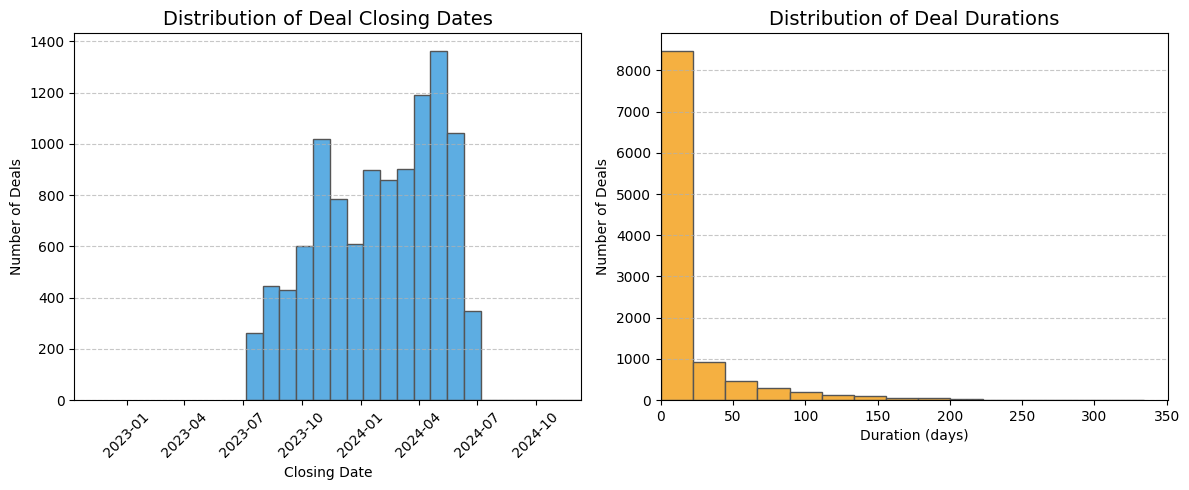

In [8]:
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Unified constants
FIGSIZE = (12, 5)
TITLE_FONT = 14
LABEL_FONT = 10
TICKS_FONT = 10
DATA_LABEL_FONT = 10

# Use your custom palette
PALETTE_DATES = '#5DADE2'    # голубой
PALETTE_DURATION = '#F5B041' # персиковый
EDGE_COLOR = '#555555'       # серый for edges

# Calculate the duration from deal creation to closure
deals_contacts['Duration'] = (deals_contacts['Closing Date'] - deals_contacts['Created Time_x']).dt.days

# Define the time range for visualizations
min_date = deals_contacts['Closing Date'].min()
max_date = deals_contacts['Closing Date'].max()

# Filter out invalid durations (remove negative values)
deals_contacts_filtered = deals_contacts[deals_contacts['Duration'] >= 0]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)

# Plot distribution of deal closing dates
axes[0].hist(deals_contacts_filtered['Closing Date'], bins=20, color=PALETTE_DATES, edgecolor=EDGE_COLOR)
axes[0].set_title('Distribution of Deal Closing Dates', fontsize=TITLE_FONT)
axes[0].set_xlabel('Closing Date', fontsize=LABEL_FONT)
axes[0].set_ylabel('Number of Deals', fontsize=LABEL_FONT)
axes[0].set_xlim([min_date, max_date])
axes[0].tick_params(axis='x', labelsize=TICKS_FONT, rotation=45)
axes[0].tick_params(axis='y', labelsize=TICKS_FONT)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot distribution of deal durations
axes[1].hist(deals_contacts_filtered['Duration'], bins=15, color=PALETTE_DURATION, edgecolor=EDGE_COLOR)
axes[1].set_title('Distribution of Deal Durations', fontsize=TITLE_FONT)
axes[1].set_xlabel('Duration (days)', fontsize=LABEL_FONT)
axes[1].set_ylabel('Number of Deals', fontsize=LABEL_FONT)
axes[1].set_xlim(left=0)
axes[1].tick_params(axis='x', labelsize=TICKS_FONT)
axes[1].tick_params(axis='y', labelsize=TICKS_FONT)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "deal_closing_dates_durations.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [9]:
# Assumes deals_contacts_filtered already exists with 'Closing Date' and 'Duration'

# 1. Distribution of Deal Closing Dates (deals per month)
closing_date_counts = (
    deals_contacts_filtered['Closing Date']
    .dt.to_period('M')
    .value_counts()
    .sort_index()
    .rename_axis('Month')
    .reset_index(name='Number of Deals')
)
closing_date_counts['Month'] = closing_date_counts['Month'].dt.to_timestamp()

# 2. Distribution of Deal Durations (deals per duration intervals)
duration_counts = (
    pd.cut(deals_contacts_filtered['Duration'], bins=20, include_lowest=True)
    .value_counts()
    .sort_index()
    .rename_axis('Duration Interval (days)')
    .reset_index(name='Number of Deals')
)

# Output tables and ranges
print("\nClosing Dates Distribution:")
print(closing_date_counts)
print(f"Range: {closing_date_counts['Month'].min()} - {closing_date_counts['Month'].max()}")

print("\nDuration Distribution:")
print(duration_counts)
print(f"Range: {deals_contacts_filtered['Duration'].min()} - {deals_contacts_filtered['Duration'].max()} days")



Closing Dates Distribution:
        Month  Number of Deals
0  2023-07-01              258
1  2023-08-01              525
2  2023-09-01              480
3  2023-10-01             1006
4  2023-11-01             1050
5  2023-12-01              750
6  2024-01-01              977
7  2024-02-01             1022
8  2024-03-01             1048
9  2024-04-01             1583
10 2024-05-01             1296
11 2024-06-01              754
12 2024-09-01                1
13 2024-12-01                1
Range: 2023-07-01 00:00:00 - 2024-12-01 00:00:00

Duration Distribution:
   Duration Interval (days)  Number of Deals
0            (-0.335, 16.7]             8021
1              (16.7, 33.4]              988
2              (33.4, 50.1]              558
3              (50.1, 66.8]              310
4              (66.8, 83.5]              236
5             (83.5, 100.2]              181
6            (100.2, 116.9]              118
7            (116.9, 133.6]               86
8            (133.6, 150.3] 

###**CONCLUSION:**

**Distribution of Deal Closing Dates** shows that the number of closed deals increases significantly starting from early 2024, peaking in February and April 2024. In other months, deal closures are more evenly distributed but occur in smaller volumes. This pattern may indicate seasonal fluctuations or the influence of specific factors during those peak months that drive higher deal closure activity.

**Distribution of Deal Durations** (time from creation to closure) demonstrates that the majority of deals are closed within the first 10 days, reflecting high efficiency in the sales process. However, there are outliers where deals take much longer—up to 140 days—although such cases are rare. While most deals are handled quickly, these extended durations highlight the need for further investigation to understand bottlenecks and improve sales cycle consistency.

###**4. Campaign Performance Analysis:**

**4.1. Compare the performance of different campaigns in terms of lead generation and conversion rat**


In [10]:
# Grouping by campaigns
campaign_stats = deals.groupby("Campaign Name").agg(
    total_leads=("Deal ID", "count"),
    won_deals=("Payment Status", lambda x: (x == "Paid").sum()),
    total_revenue=("Offer Total Amount (EUR)", "sum"),
    avg_deal_value=("Offer Total Amount (EUR)", "mean")
).reset_index()

# Calculating conversion rate
campaign_stats["conversion_rate"] = round(
    100 * campaign_stats["won_deals"] / campaign_stats["total_leads"], 2
)

# Sorting by total leads and keeping top 15
campaign_stats = campaign_stats.sort_values("total_leads", ascending=False).head(15)

print(campaign_stats)


                         Campaign Name  total_leads  won_deals  total_revenue  \
135                            unknown         4260        188       43970301   
118  performancemax_digitalmarkt_ru_DE         2573         77       24595100   
152                  youtube_shorts_DE         1596         30       16570600   
18                   12.07.2023wide_DE         1531         29       15715400   
2                      02.07.23wide_DE          943         28        9163100   
5             04.07.23recentlymoved_DE          734         16        7383100   
4                        03.07.23women          596         15        5969698   
60                              Dis_DE          567         17        6035800   
8                       07.07.23LAL_DE          529         13        5290500   
19           12.09.23interests_Uxui_DE          515         15        5434300   
40              24.09.23retargeting_DE          472          9        5061400   
144                        w

Saved: /content/png_projekt/leads_conversion_by_campaign.png


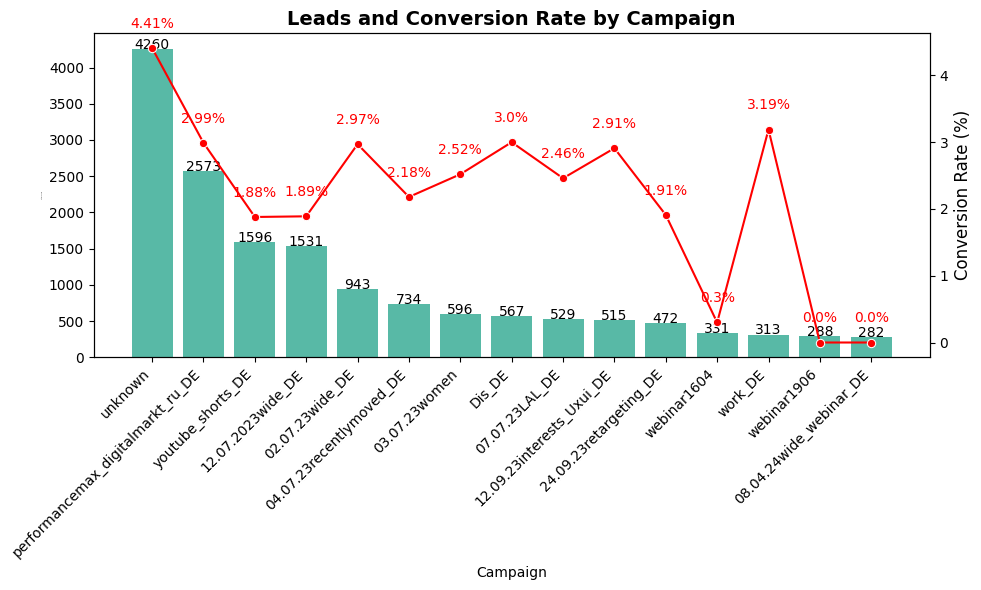

In [11]:
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Unified figure size
FIGSIZE = (10, 6)

# --- Conversion on a combined chart with annotations ---
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Bars: total leads per campaign
bars = sns.barplot(
    x="Campaign Name",
    y="total_leads",
    data=campaign_stats,
    ax=ax1,
    color="#48C9B0"
)
ax1.set_xlabel("Campaign", fontsize=10)
ax1.set_ylabel("Total Leads", color="black", fontsize=1)
ax1.tick_params(axis='y', labelcolor='black')
plt.xticks(rotation=45, ha="right")

# Annotate bar values
for p in bars.patches:
    height = p.get_height()
    ax1.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',
        ha="center",
        fontsize=10
    )

# Line: conversion rate
ax2 = ax1.twinx()
line = sns.lineplot(
    x="Campaign Name",
    y="conversion_rate",
    data=campaign_stats,
    ax=ax2,
    color="red",
    marker="o"
)
ax2.set_ylabel("Conversion Rate (%)", color="black", fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Annotate conversion points
for x, y in zip(range(len(campaign_stats)), campaign_stats["conversion_rate"]):
    ax2.text(
        x,
        y + 0.3,
        f'{y}%',
        color="red",
        ha="center",
        fontsize=10
    )

plt.title("Leads and Conversion Rate by Campaign", fontsize=14, fontweight='bold')
plt.tight_layout()

# --- Save figure ---
filename = os.path.join(output_dir, "leads_conversion_by_campaign.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [12]:
# --- Create a table with campaign data for plotting ---
campaign_table = campaign_stats[['Campaign Name', 'total_leads', 'won_deals',
                                 'conversion_rate', 'total_revenue', 'avg_deal_value']].copy()

# Format conversion rate as percentage with 2 decimals
campaign_table['conversion_rate'] = campaign_table['conversion_rate'].apply(lambda x: f"{x:.2f}%")

# Display the table
print("\nTable with campaign data for the 'Leads and Conversion' chart:")
display(campaign_table)



Table with campaign data for the 'Leads and Conversion' chart:


,Campaign Name,total_leads,won_deals,conversion_rate,total_revenue,avg_deal_value
135,unknown,4260,188,4.41%,43970301,10321.666901
118,performancemax_digitalmarkt_ru_DE,2573,77,2.99%,24595100,9558.919549
152,youtube_shorts_DE,1596,30,1.88%,16570600,10382.581454
18,12.07.2023wide_DE,1531,29,1.89%,15715400,10264.794252
2,02.07.23wide_DE,943,28,2.97%,9163100,9716.967126
5,04.07.23recentlymoved_DE,734,16,2.18%,7383100,10058.719346
4,03.07.23women,596,15,2.52%,5969698,10016.271812
60,Dis_DE,567,17,3.00%,6035800,10645.149912
8,07.07.23LAL_DE,529,13,2.46%,5290500,10000.94518
19,12.09.23interests_Uxui_DE,515,15,2.91%,5434300,10552.038835


###**4.2. Evaluate the effectiveness of different marketing Sources in generating high-quality leads.**

Saved: /content/png_projekt/high_quality_leads_by_source_mint_gradient.png


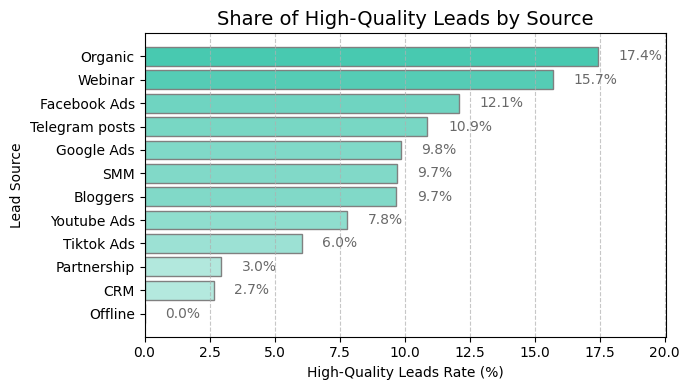

In [13]:
import matplotlib.colors as mcolors
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Unified figure size
FIGSIZE = (7, 4)
BASE_COLOR_HEX = '#48C9B0'  # Mint color

# Prepare the data
high_quality_deals = deals[(deals['Lead Source'] != 'Test') &
                           (deals['Quality'].isin(['A - High', 'B - Medium']))]

quality_leads = high_quality_deals.groupby('Lead Source', observed=False).size().reset_index(name='High Quality Leads')
source_leads = deals[deals['Lead Source'] != 'Test'].groupby('Lead Source', observed=False).size().reset_index(name='Leads')

# Merge data
source_quality = pd.merge(source_leads, quality_leads, on='Lead Source', how='left')
source_quality['High Quality Leads'] = source_quality['High Quality Leads'].fillna(0)
source_quality['High Quality Rate'] = source_quality['High Quality Leads'] / source_quality['Leads'] * 100

# Sort ascending
sorted_data = source_quality.sort_values('High Quality Rate', ascending=True).reset_index(drop=True)

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE)

# Convert hex to RGBA
base_rgba = mcolors.to_rgba(BASE_COLOR_HEX)

# Gradient colors: scale alpha from 0.3 to 1.0
max_val = sorted_data['High Quality Rate'].max()
colors = [(*base_rgba[:3], 0.3 + 0.7*(v/max_val)) for v in sorted_data['High Quality Rate']]

# Horizontal bar chart
bars = ax.barh(sorted_data['Lead Source'],
               sorted_data['High Quality Rate'],
               color=colors, edgecolor='gray')

# Titles and labels
ax.set_title('Share of High-Quality Leads by Source', fontsize=14)
ax.set_xlabel('High-Quality Leads Rate (%)', fontsize=10)
ax.set_ylabel('Lead Source', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Extend X-axis for labels
ax.set_xlim(0, sorted_data['High Quality Rate'].max() * 1.15)

# Add labels at the end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.8, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%",
            va='center', fontsize=10, color="dimgray")

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "high_quality_leads_by_source_mint_gradient.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [14]:
# Prepare the data
high_quality_deals = deals[(deals['Lead Source'] != 'Test') &
                           (deals['Quality'].isin(['A - High', 'B - Medium']))]

# Group by Lead Source
quality_leads = high_quality_deals.groupby('Lead Source', observed=False).size().reset_index(name='High Quality Leads')
source_leads = deals[deals['Lead Source'] != 'Test'].groupby('Lead Source', observed=False).size().reset_index(name='Leads')

# Merge data
source_quality = pd.merge(source_leads, quality_leads, on='Lead Source', how='left')
source_quality['High Quality Leads'] = source_quality['High Quality Leads'].fillna(0)
source_quality['High Quality Rate (%)'] = source_quality['High Quality Leads'] / source_quality['Leads'] * 100

# Sort by High Quality Rate descending
source_quality = source_quality.sort_values('High Quality Rate (%)', ascending=False).reset_index(drop=True)

# Display pivot table
pivot_table = source_quality[['Lead Source', 'Leads', 'High Quality Leads', 'High Quality Rate (%)']]
print(pivot_table)


       Lead Source  Leads  High Quality Leads  High Quality Rate (%)
0          Organic   1504                 262              17.420213
1          Webinar    306                  48              15.686275
2     Facebook Ads   4731                 572              12.090467
3   Telegram posts    993                 108              10.876133
4       Google Ads   4115                 405               9.842041
5              SMM   1671                 162               9.694794
6         Bloggers   1075                 104               9.674419
7      Youtube Ads   1618                 126               7.787392
8       Tiktok Ads   2003                 121               6.040939
9      Partnership    203                   6               2.955665
10             CRM   1470                  39               2.653061
11         Offline      2                   0               0.000000
12            Test      0                   0                    NaN


**High-Quality Leads Analysis (Summary):**

Top sources: Organic (17.4%), Webinar (15.7%), Facebook Ads (12.1%), Telegram posts (10.9%) — attract high-quality leads with better conversion potential.

Moderate sources: Google Ads, SMM, Bloggers, YouTube Ads (7–10%) — effective but below top performers.

Low-performing sources: Tiktok Ads, Partnership, CRM, Offline (<6%) — need review or optimization.

Recommendation: Focus on Organic, Webinar, Facebook Ads, and Telegram posts; reassess low-performing channels.

###**5. Sales Team Performance Analysis:**

**5.1. Evaluate the performance of individual deal owners and marketing campaigns based on:**

Number of deals handled

Conversion rate

Total sales amount

/tmp/ipython-input-1295561812.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  manager_perf = deals[deals['Manager Name'].astype(str).str.lower() != 'unknown'].groupby('Manager Name').agg(


Saved: /content/png_projekt/top10_managers_performance.png


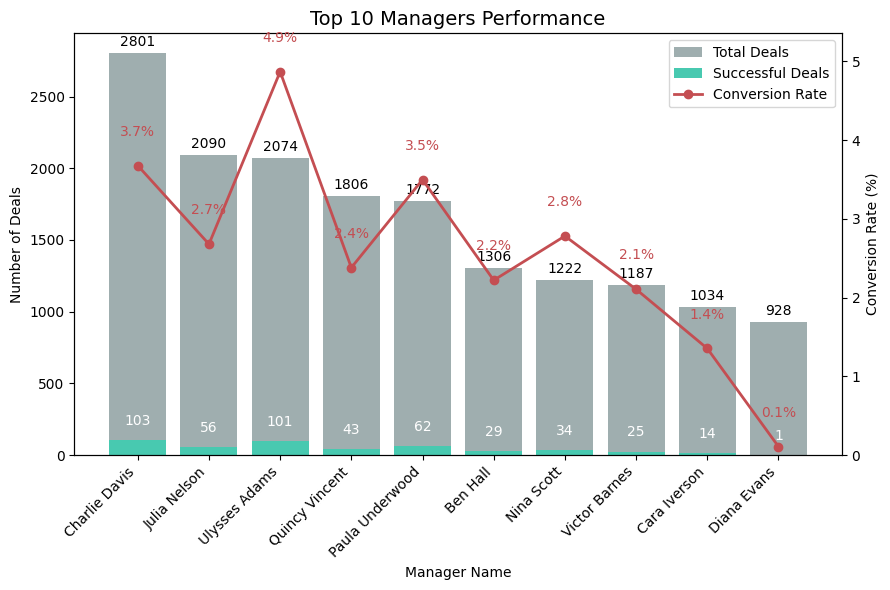

In [15]:
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Figure size and fonts
FIGSIZE = (9,6)
TITLE_FONT = 14
LABEL_FONT = 10
TICKS_FONT = 10
DATA_LABEL_FONT = 10

# --- Prepare performance for managers ---
manager_perf = deals[deals['Manager Name'].astype(str).str.lower() != 'unknown'].groupby('Manager Name').agg(
    Total_Deals=('Deal ID', 'nunique'),
    Successful_Deals=('Payment Status', lambda x: (x=='Paid').sum())
).reset_index()
manager_perf['Conversion Rate'] = manager_perf['Successful_Deals'] / manager_perf['Total_Deals'] * 100

# Keep top 10 by Total Deals
manager_perf = manager_perf.sort_values('Total_Deals', ascending=False).head(10)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Bars for Total and Successful Deals
bars_total = ax1.bar(manager_perf['Manager Name'], manager_perf['Total_Deals'], color='#95A5A6', alpha=0.9, label='Total Deals')
bars_success = ax1.bar(manager_perf['Manager Name'], manager_perf['Successful_Deals'], color='#48C9B0', label='Successful Deals')

# Annotate bars
for bar in bars_total:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(manager_perf['Total_Deals'])*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT)
for bar in bars_success:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(manager_perf['Total_Deals'])*0.03,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT, color='white')

# Line for Conversion Rate (red)
ax2 = ax1.twinx()
line = ax2.plot(manager_perf['Manager Name'], manager_perf['Conversion Rate'], color='#C44E52', marker='o', linewidth=2, label='Conversion Rate')

# Adjust ylim so labels fit
ax2.set_ylim(0, max(manager_perf['Conversion Rate'])*1.1)

# Annotate conversion rates
for i, rate in enumerate(manager_perf['Conversion Rate']):
    ax2.text(i, rate + max(manager_perf['Conversion Rate'])*0.07, f"{rate:.1f}%", ha='center', va='bottom', fontsize=DATA_LABEL_FONT, color='#C44E52')

# Titles and labels
ax1.set_title('Top 10 Managers Performance', fontsize=TITLE_FONT)
ax1.set_xlabel('Manager Name', fontsize=LABEL_FONT)
ax1.set_ylabel('Number of Deals', fontsize=LABEL_FONT)
ax2.set_ylabel('Conversion Rate (%)', fontsize=LABEL_FONT)

# Improve X-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=TICKS_FONT)

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=TICKS_FONT)

# Remove grids
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "top10_managers_performance.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [16]:
# Show top 10 managers performance as a table
manager_perf_display = manager_perf.copy()

# Round conversion rate
manager_perf_display['Conversion Rate (%)'] = manager_perf_display['Conversion Rate'].round(1)

# Reorder columns for readability
manager_perf_display = manager_perf_display[['Manager Name', 'Total_Deals', 'Successful_Deals', 'Conversion Rate (%)']]

# Display in notebook
manager_perf_display


,Manager Name,Total_Deals,Successful_Deals,Conversion Rate (%)
5,Charlie Davis,2801,103,3.7
12,Julia Nelson,2090,56,2.7
21,Ulysses Adams,2074,101,4.9
18,Quincy Vincent,1806,43,2.4
17,Paula Underwood,1772,62,3.5
2,Ben Hall,1306,29,2.2
15,Nina Scott,1222,34,2.8
22,Victor Barnes,1187,25,2.1
4,Cara Iverson,1034,14,1.4
6,Diana Evans,928,1,0.1


Saved: /content/png_projekt/top10_campaigns_performance.png


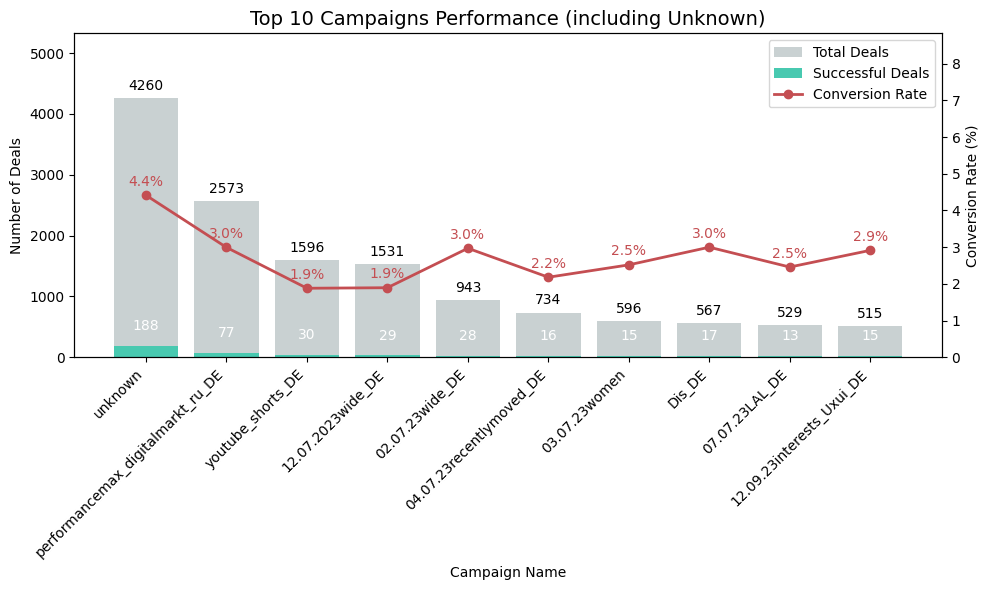

In [17]:
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Figure size and fonts
FIGSIZE = (10,6)
TITLE_FONT = 14
LABEL_FONT = 10
TICKS_FONT = 10
DATA_LABEL_FONT = 10

# --- Prepare performance for campaigns including 'unknown' ---
campaign_perf = deals.groupby('Campaign Name').agg(
    Total_Deals=('Deal ID', 'nunique'),
    Successful_Deals=('Payment Status', lambda x: (x=='Paid').sum())
).reset_index()

# Replace empty strings with 'Unknown' for clarity
campaign_perf['Campaign Name'] = campaign_perf['Campaign Name'].replace('', 'Unknown')

# Calculate Conversion Rate
campaign_perf['Conversion Rate'] = campaign_perf['Successful_Deals'] / campaign_perf['Total_Deals'] * 100

# Keep top 10 by Total Deals
campaign_perf = campaign_perf.sort_values('Total_Deals', ascending=False).head(10)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Bars for Total and Successful Deals
bars_total = ax1.bar(campaign_perf['Campaign Name'], campaign_perf['Total_Deals'], color='#95A5A6', alpha=0.5, label='Total Deals')
bars_success = ax1.bar(campaign_perf['Campaign Name'], campaign_perf['Successful_Deals'], color='#48C9B0', label='Successful Deals')

# Adjust left Y-axis limit to leave space for labels
ax1.set_ylim(0, max(campaign_perf['Total_Deals'])*1.25)

# Annotate bars
for bar in bars_total:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(campaign_perf['Total_Deals'])*0.02,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT)
for bar in bars_success:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(campaign_perf['Total_Deals'])*0.05,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT, color='white')

# Line for Conversion Rate (red)
ax2 = ax1.twinx()
line = ax2.plot(campaign_perf['Campaign Name'], campaign_perf['Conversion Rate'], color='#C44E52', marker='o', linewidth=2, label='Conversion Rate')

# Adjust right Y-axis limit
ax2.set_ylim(0, max(campaign_perf['Conversion Rate'])*2)

# Annotate conversion rates
for i, rate in enumerate(campaign_perf['Conversion Rate']):
    ax2.text(i, rate + max(campaign_perf['Conversion Rate'])*0.04, f"{rate:.1f}%", ha='center', va='bottom', fontsize=DATA_LABEL_FONT, color='#C44E52')

# Titles and labels
ax1.set_title('Top 10 Campaigns Performance (including Unknown)', fontsize=TITLE_FONT)
ax1.set_xlabel('Campaign Name', fontsize=LABEL_FONT)
ax1.set_ylabel('Number of Deals', fontsize=LABEL_FONT)
ax2.set_ylabel('Conversion Rate (%)', fontsize=LABEL_FONT)

# Improve X-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=TICKS_FONT)

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=TICKS_FONT)

# Remove grid
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "top10_campaigns_performance.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [18]:
# Show top 10 campaigns performance as a table
campaign_perf_display = campaign_perf.copy()

# Round conversion rate
campaign_perf_display['Conversion Rate (%)'] = campaign_perf_display['Conversion Rate'].round(1)

# Reorder columns for readability
campaign_perf_display = campaign_perf_display[['Campaign Name', 'Total_Deals', 'Successful_Deals', 'Conversion Rate (%)']]

# Display in notebook
campaign_perf_display


,Campaign Name,Total_Deals,Successful_Deals,Conversion Rate (%)
135,unknown,4260,188,4.4
118,performancemax_digitalmarkt_ru_DE,2573,77,3.0
152,youtube_shorts_DE,1596,30,1.9
18,12.07.2023wide_DE,1531,29,1.9
2,02.07.23wide_DE,943,28,3.0
5,04.07.23recentlymoved_DE,734,16,2.2
4,03.07.23women,596,15,2.5
60,Dis_DE,567,17,3.0
8,07.07.23LAL_DE,529,13,2.5
19,12.09.23interests_Uxui_DE,515,15,2.9


/tmp/ipython-input-1347041462.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_perf = deals.groupby('Lead Source').agg(


Saved: /content/png_projekt/top10_leadsource_performance.png


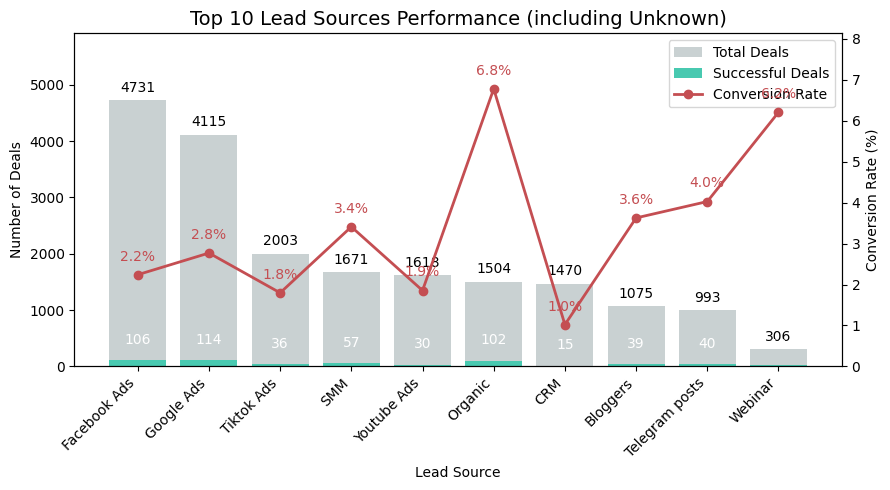

In [19]:
# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Figure size and fonts
FIGSIZE = (9,5)
TITLE_FONT = 14
LABEL_FONT = 10
TICKS_FONT = 10
DATA_LABEL_FONT = 10

# --- Prepare performance for Lead Source (including Unknown) ---
lead_perf = deals.groupby('Lead Source').agg(
    Total_Deals=('Deal ID', 'nunique'),
    Successful_Deals=('Payment Status', lambda x: (x == 'Paid').sum())
).reset_index()

# Replace empty strings with 'Unknown' for clarity
lead_perf['Lead Source'] = lead_perf['Lead Source'].replace('', 'unknown')

# Calculate Conversion Rate
lead_perf['Conversion Rate'] = lead_perf['Successful_Deals'] / lead_perf['Total_Deals'] * 100

# Keep top 10 by Total Deals
lead_perf = lead_perf.sort_values('Total_Deals', ascending=False).head(10)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Bars for Total and Successful Deals
bars_total = ax1.bar(lead_perf['Lead Source'], lead_perf['Total_Deals'],
                     color='#95A5A6', alpha=0.5, label='Total Deals')
bars_success = ax1.bar(lead_perf['Lead Source'], lead_perf['Successful_Deals'],
                       color='#48C9B0', label='Successful Deals')

# Adjust left Y-axis limit to leave space for labels
ax1.set_ylim(0, max(lead_perf['Total_Deals']) * 1.25)

# Annotate bars
for bar in bars_total:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(lead_perf['Total_Deals']) * 0.02,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT)
for bar in bars_success:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(lead_perf['Total_Deals']) * 0.05,
             f'{int(height)}', ha='center', va='bottom', fontsize=DATA_LABEL_FONT, color='white')

# Line for Conversion Rate (red)
ax2 = ax1.twinx()
line = ax2.plot(lead_perf['Lead Source'], lead_perf['Conversion Rate'],
                color='#C44E52', marker='o', linewidth=2, label='Conversion Rate')

# Adjust right Y-axis limit
ax2.set_ylim(0, max(lead_perf['Conversion Rate']) * 1.2)

# Annotate conversion rates
for i, rate in enumerate(lead_perf['Conversion Rate']):
    ax2.text(i, rate + max(lead_perf['Conversion Rate']) * 0.04,
             f"{rate:.1f}%", ha='center', va='bottom',
             fontsize=DATA_LABEL_FONT, color='#C44E52')

# Titles and labels
ax1.set_title('Top 10 Lead Sources Performance (including Unknown)', fontsize=TITLE_FONT)
ax1.set_xlabel('Lead Source', fontsize=LABEL_FONT)
ax1.set_ylabel('Number of Deals', fontsize=LABEL_FONT)
ax2.set_ylabel('Conversion Rate (%)', fontsize=LABEL_FONT)

# Improve X-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=TICKS_FONT)

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=TICKS_FONT)

# Remove grid
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "top10_leadsource_performance.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [20]:
# --- Prepare Lead Source performance table ---
lead_table = deals.groupby('Lead Source').agg(
    Total_Deals=('Deal ID', 'nunique'),
    Successful_Deals=('Payment Status', lambda x: (x == 'Paid').sum())
).reset_index()

# Replace empty strings with 'Unknown'
lead_table['Lead Source'] = lead_table['Lead Source'].replace('', 'Unknown')

# Calculate Conversion Rate (%)
lead_table['Conversion Rate (%)'] = lead_table['Successful_Deals'] / lead_table['Total_Deals'] * 100

# Keep top 10 by Total Deals
lead_table = lead_table.sort_values('Total_Deals', ascending=False).head(10).reset_index(drop=True)

# Display the table
print("Top 10 Lead Sources Performance (including Unknown):")
display(lead_table)


Top 10 Lead Sources Performance (including Unknown):


/tmp/ipython-input-4172531244.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_table = deals.groupby('Lead Source').agg(


,Lead Source,Total_Deals,Successful_Deals,Conversion Rate (%)
0,Facebook Ads,4731,106,2.240541
1,Google Ads,4115,114,2.770352
2,Tiktok Ads,2003,36,1.797304
3,SMM,1671,57,3.411131
4,Youtube Ads,1618,30,1.854141
5,Organic,1504,102,6.781915
6,CRM,1470,15,1.020408
7,Bloggers,1075,39,3.627907
8,Telegram posts,993,40,4.028197
9,Webinar,306,19,6.209150


/tmp/ipython-input-976098092.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  manager_sales_success = deals[deals['Payment Status']=='Paid'].groupby('Manager Name').agg(


Saved: /content/png_projekt/top10_managers_sales_peach_gradient.png


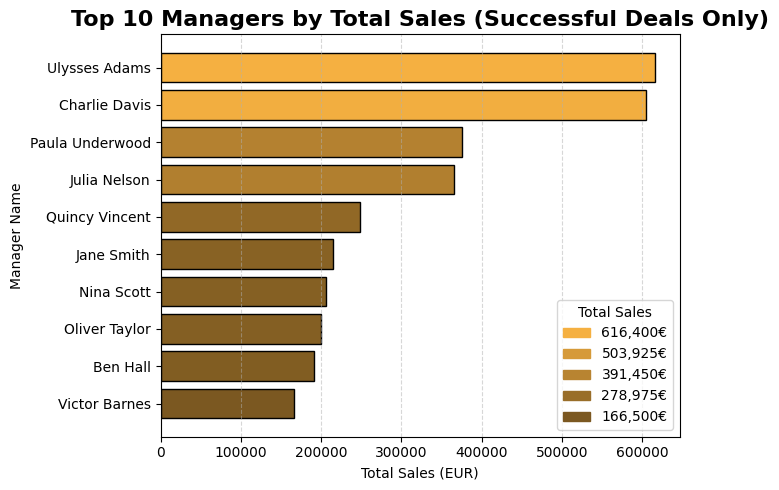

In [21]:
manager_sales_success = deals[deals['Payment Status']=='Paid'].groupby('Manager Name').agg(
    Total_Sales_EUR=('Offer Total Amount (EUR)', 'sum')
).reset_index().sort_values(by='Total_Sales_EUR', ascending=False).head(10)

# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

#  Horizontal bar chart with gradient (top 10 managers)
fig,ax = plt.subplots(figsize=(7,5))

# Base color: peach
base_color = np.array([245, 176, 65])/255  # #F5B041 in RGB normalized

# Normalize sales for gradient (0 -> min, 1 -> max)
norm = mpl.colors.Normalize(
    vmin=manager_sales_success['Total_Sales_EUR'].min(),
    vmax=manager_sales_success['Total_Sales_EUR'].max()
)

# Generate gradient colors based on normalized sales
colors = [base_color * 0.5 + base_color * 0.5 * norm(val) for val in manager_sales_success['Total_Sales_EUR']]
colors = [tuple(c) for c in colors]  # convert to tuples for matplotlib

# Plot horizontal bars
bars = ax.barh(
    manager_sales_success['Manager Name'],
    manager_sales_success['Total_Sales_EUR'],
    color=colors,
    edgecolor='black'
)

# Add grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.invert_yaxis()  # Top sales first

# Create custom legend with 5 values (descending)
min_val = manager_sales_success['Total_Sales_EUR'].min()
max_val = manager_sales_success['Total_Sales_EUR'].max()
step = (max_val - min_val) / 4
legend_values = [max_val - step*i for i in range(5)]

# Generate gradient colors for legend
legend_colors = [tuple(base_color * 0.5 + base_color * 0.5 * ((val - min_val)/(max_val - min_val))) for val in legend_values]
legend_patches = [mpatches.Patch(color=col, label=f'{int(val):,}€') for col, val in zip(legend_colors, legend_values)]
ax.legend(handles=legend_patches, title='Total Sales', loc='lower right', fontsize=10)

# Titles and labels
ax.set_title('Top 10 Managers by Total Sales (Successful Deals Only)', fontsize=16, fontweight='bold')
ax.set_xlabel('Total Sales (EUR)', fontsize=10)
ax.set_ylabel('Manager Name', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "top10_managers_sales_peach_gradient.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [22]:
# Show top 10 managers by total sales as a table
manager_sales_success_display = manager_sales_success.copy()
manager_sales_success_display['Total Sales (EUR)'] = manager_sales_success_display['Total_Sales_EUR'].apply(lambda x: f"{x:,.0f} €")

# Reorder columns for readability
manager_sales_success_display = manager_sales_success_display[['Manager Name', 'Total Sales (EUR)']]

# Display in notebook (as numbers, not a chart)
manager_sales_success_display


,Manager Name,Total Sales (EUR)
21,Ulysses Adams,"616,400 €"
5,Charlie Davis,"605,100 €"
17,Paula Underwood,"376,000 €"
12,Julia Nelson,"366,201 €"
18,Quincy Vincent,"248,500 €"
10,Jane Smith,"215,500 €"
15,Nina Scott,"205,900 €"
16,Oliver Taylor,"200,500 €"
2,Ben Hall,"191,500 €"
22,Victor Barnes,"166,500 €"


###**6. Payments and Products Analysis:**

####**6.1.** Examine the distribution of payment types and their impact on deal success.


Saved: /content/png_projekt/payment_performance.png


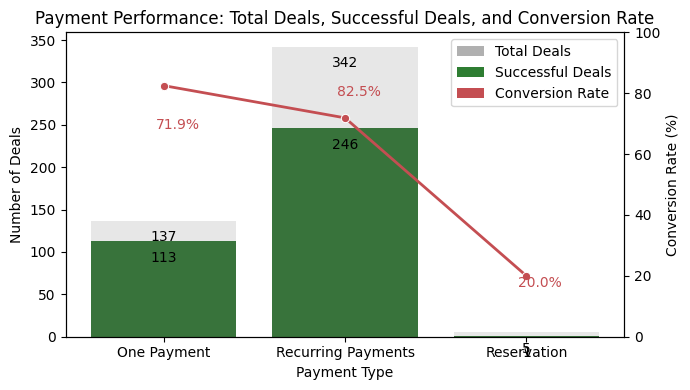

In [23]:

# Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Unified figure size
FIGSIZE = (7, 4)

# Filter out 'Unknown' Payment Types
payment_filtered = deals[~deals['Payment Type'].astype(str).str.lower().isin(['unknown', ''])]

# Aggregate total and successful deals
total_payments = payment_filtered.groupby('Payment Type', observed=True)['Deal ID'].nunique().reset_index(name='Total Deals')
successful_payments = payment_filtered[payment_filtered['Payment Status'] == 'Paid'] \
                      .groupby('Payment Type', observed=True)['Deal ID'].nunique().reset_index(name='Successful Deals')

# Merge and calculate conversion rate
payment_perf = pd.merge(total_payments, successful_payments, on='Payment Type', how='left')
payment_perf['Successful Deals'] = payment_perf['Successful Deals'].fillna(0)
payment_perf['Conversion Rate (%)'] = (payment_perf['Successful Deals'] / payment_perf['Total Deals'] * 100).round(1)
payment_perf = payment_perf.sort_values('Total Deals', ascending=False)

# Colors
color_total = '#B0B0B0'
color_success = '#2E7D32'
color_conv = '#C44E52'

#  Create figure
fig, ax1 = plt.subplots(figsize=FIGSIZE)

#  Plot bars
sns.barplot(x='Payment Type', y='Total Deals', data=payment_perf, color=color_total, alpha=0.3, ax=ax1)
sns.barplot(x='Payment Type', y='Successful Deals', data=payment_perf, color=color_success, alpha=1.0, ax=ax1)

#  Secondary axis for conversion rate
ax2 = ax1.twinx()
sns.lineplot(x='Payment Type', y='Conversion Rate (%)', data=payment_perf, color=color_conv, marker='o', linewidth=2, ax=ax2)

# Annotate bar values inside bars
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{int(height)}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, -12),
                 textcoords='offset points')

#  Annotate conversion rate values above points
for x, y in zip(range(len(payment_perf)), payment_perf['Conversion Rate (%)']):
    ax2.annotate(f'{y:.1f}%', (x, y), ha='center', va='bottom', fontsize=10, color=color_conv, xytext=(10, -10),
                 textcoords='offset points')

# Titles and labels
ax1.set_title('Payment Performance: Total Deals, Successful Deals, and Conversion Rate', fontsize=12)
ax1.set_xlabel('Payment Type', fontsize=10)
ax1.set_ylabel('Number of Deals', fontsize=10)
ax2.set_ylabel('Conversion Rate (%)', fontsize=10)
ax2.set_ylim(0, 100)

#  Custom legend
legend_elements = [
    Patch(facecolor=color_total, label='Total Deals'),
    Patch(facecolor=color_success, label='Successful Deals'),
    Patch(facecolor=color_conv, label='Conversion Rate')
]
ax1.legend(handles=legend_elements, loc='upper right')

#  Remove gridlines
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

#  Save figure
filename = os.path.join(output_dir, "payment_performance.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [24]:
# --- Filter out 'Unknown' Payment Types ---
payment_filtered = deals[~deals['Payment Type'].astype(str).str.lower().isin(['unknown', ''])]

# --- Aggregate total and successful deals ---
total_payments = payment_filtered.groupby('Payment Type', observed=True)['Deal ID'].nunique().reset_index(name='Total Deals')
successful_payments = payment_filtered[payment_filtered['Payment Status'] == 'Paid'] \
                      .groupby('Payment Type', observed=True)['Deal ID'].nunique().reset_index(name='Successful Deals')

# --- Merge and calculate conversion rate ---
payment_perf = pd.merge(total_payments, successful_payments, on='Payment Type', how='left')
payment_perf['Successful Deals'] = payment_perf['Successful Deals'].fillna(0)
payment_perf['Conversion Rate (%)'] = (payment_perf['Successful Deals'] / payment_perf['Total Deals'] * 100).round(1)

# --- Sort by total deals ---
payment_perf = payment_perf.sort_values('Total Deals', ascending=False)

# --- Display the table ---
print("Payment Performance Table:")
display(payment_perf)


Payment Performance Table:


,Payment Type,Total Deals,Successful Deals,Conversion Rate (%)
1,Recurring Payments,342,246,71.9
0,One Payment,137,113,82.5
2,Reservation,5,1,20.0


###**6.2. Analyze the popularity and success of different products and education types.**

####**Let's display a table showing the calculated metrics by education type:**

The number of deals for each education type

The number of successful deals for each education type

The total payments for successful deals for each education type (with status "Payment Done")

The conversion rate for each education type

In [25]:
# --- Convert data type to string and filter for specific education types ---
filtered_deals = deals[deals['Education Type'].astype(str).isin(['Morning', 'Evening'])]

# --- Count total unique deals for each education type ---
education_deals = filtered_deals.groupby('Education Type', observed=True)['Deal ID'].nunique().reset_index(name='Total Deals')

# --- Count successful deals (Payment Status = Paid) for each education type ---
successful_education_deals = filtered_deals[filtered_deals['Payment Status'] == 'Paid'] \
                             .groupby('Education Type', observed=True)['Deal ID'].nunique().reset_index(name='Successful Deals')

# --- Sum total payments (EUR) for each education type ---
total_sales_education = filtered_deals[filtered_deals['Payment Status'] == 'Paid'] \
                        .groupby('Education Type', observed=True)['Offer Total Amount (EUR)'].sum().reset_index()

# --- Merge all metrics into one dataframe ---
education_performance = pd.merge(education_deals, successful_education_deals, on='Education Type', how='left')
education_performance = pd.merge(education_performance, total_sales_education, on='Education Type', how='left')

# --- Fill NaN values and calculate conversion rate ---
education_performance['Successful Deals'] = education_performance['Successful Deals'].fillna(0)
education_performance['Offer Total Amount (EUR)'] = education_performance['Offer Total Amount (EUR)'].fillna(0)
education_performance['Conversion Rate'] = education_performance['Successful Deals'] / education_performance['Total Deals'] * 100

# --- Sort data by descending number of successful deals ---
education_performance_sorted = education_performance.sort_values(by='Successful Deals', ascending=False)

# --- Rename columns for clarity ---
education_performance_sorted.columns = ['Education Type', 'Total Deals', 'Successful Deals', 'Offer Total Amount (EUR)', 'Conversion Rate']

# --- Format values and display table without index ---
formatted_education_performance_sorted = education_performance_sorted[['Education Type', 'Total Deals', 'Successful Deals', 'Offer Total Amount (EUR)', 'Conversion Rate']].style.format({
    'Successful Deals': '{:,.0f}',
    'Offer Total Amount (EUR)': '{:,.0f}',
    'Conversion Rate': '{:.2f}'
}).hide(axis='index')

# --- Display the formatted table ---
display(formatted_education_performance_sorted)


Education Type,Total Deals,Successful Deals,Offer Total Amount (EUR),Conversion Rate
Morning,2860,383,"2,815,600",13.39
Evening,399,171,"626,300",42.86


###**Conclusion:**
 Although morning classes generate more deals overall, evening classes are significantly more effective in converting deals into successful payments.

###**Let’s create a table showing the metrics calculated by product, taking into account the type of education**:

Total number of deals for each product

Number of successful deals for each product (with status "Paid")

Total payments for successful deals for each product

Conversion rate for each product

In [26]:
# --- Calculate total number of unique deals for each product and education type ---
product_education_deals = deals.groupby(['Course Name', 'Education Type'], observed=True)['Deal ID'].nunique().reset_index(name='Total Deals')

# --- Calculate number of successful deals (Payment Status = 'Paid') for each product and education type ---
successful_product_education_deals = deals[deals['Payment Status'] == 'Paid'].groupby(['Course Name', 'Education Type'], observed=True)['Deal ID'].nunique().reset_index(name='Successful Deals')

# --- Calculate total payments for successful deals for each product and education type ---
total_sales_product_education = deals[deals['Payment Status'] == 'Paid'].groupby(['Course Name', 'Education Type'], observed=True)['Offer Total Amount (EUR)'].sum().reset_index()

# --- Merge dataframes ---
product_education_performance = pd.merge(product_education_deals, successful_product_education_deals, on=['Course Name', 'Education Type'], how='left')
product_education_performance = pd.merge(product_education_performance, total_sales_product_education, on=['Course Name', 'Education Type'], how='left')

# --- Fill NaN values and calculate conversion rate ---
product_education_performance['Successful Deals'] = product_education_performance['Successful Deals'].fillna(0)
product_education_performance['Offer Total Amount (EUR)'] = product_education_performance['Offer Total Amount (EUR)'].fillna(0)
product_education_performance['Conversion Rate'] = product_education_performance['Successful Deals'] / product_education_performance['Total Deals'] * 100

# --- Sort data by number of successful deals in descending order ---
product_education_performance_sorted = product_education_performance.sort_values(by='Successful Deals', ascending=False)

# --- Rename columns for clarity ---
product_education_performance_sorted.columns = ['Course Name', 'Education Type', 'Total Deals', 'Successful Deals', 'Offer Total Amount (EUR)', 'Conversion Rate']

# --- Exclude empty, "unknown", or invalid values ---
product_education_performance_sorted = product_education_performance_sorted[
    product_education_performance_sorted['Course Name'].notnull() &
    (product_education_performance_sorted['Course Name'] != 'unknown') &
    product_education_performance_sorted['Education Type'].notnull() &
    (product_education_performance_sorted['Education Type'] != '#REF!') &
    (product_education_performance_sorted['Education Type'] != 'unknown')
]

# --- Format table values for display ---
formatted_product_education_performance_sorted = product_education_performance_sorted[['Course Name', 'Education Type', 'Total Deals', 'Successful Deals', 'Offer Total Amount (EUR)', 'Conversion Rate']].style.format({
    'Total Deals': '{:,.0f}',
    'Successful Deals': '{:,.0f}',
    'Offer Total Amount (EUR)': '{:,.0f}',
    'Conversion Rate': '{:.2f}'
}).hide(axis='index')

# --- Display the formatted table ---
display(formatted_product_education_performance_sorted)


Course Name,Education Type,Total Deals,Successful Deals,Offer Total Amount (EUR),Conversion Rate
Digital Marketing,Morning,"1,510",195,"1,689,100",12.91
Digital Marketing,Evening,246,113,"408,800",45.93
UX/UI Design,Morning,803,99,"823,400",12.33
Web Development,Morning,538,89,"303,100",16.54
UX/UI Design,Evening,152,58,"217,500",38.16
Web Development,Evening,1,0,0,0.00


###**Insights:**

Evening courses generally have fewer participants but much higher success rates.

Morning sessions attract larger volumes but achieve lower conversion.

Focusing on strategies to improve morning session conversions or expanding high-converting evening sessions could optimize overall performance.

Saved: /content/png_projekt/product_performance_by_education.png


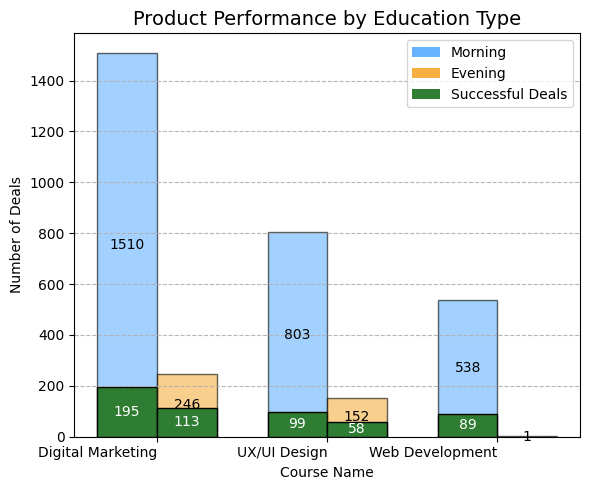

In [27]:
# --- Filter data ---
df = product_education_performance_sorted.copy()
df = df[
    df['Course Name'].notnull() &
    (df['Course Name'].str.lower() != 'unknown') &
    df['Education Type'].notnull() &
    (df['Education Type'] != '#REF!') &
    (df['Education Type'].str.lower() != 'unknown')
]

# --- Colors ---
color_total = '#B0B0B0'
color_success = '#2E7D32'
edu_colors = {'Morning': '#66B3FF', 'Evening': '#F5B041'}

# --- Prepare positions ---
courses = df['Course Name'].unique()
x = np.arange(len(courses))
width = 0.35  # width of bars

# --- Figure ---
fig, ax = plt.subplots(figsize=(6,5))

for i, course in enumerate(courses):
    for j, edu in enumerate(['Morning', 'Evening']):
        row = df[(df['Course Name'] == course) & (df['Education Type'] == edu)]
        if not row.empty:
            total = int(row['Total Deals'].values[0])
            success = int(row['Successful Deals'].values[0])
        else:
            total = success = 0
        offset = -width/2 + j*width  # Morning left, Evening right
        # Bars: total deals (colored), successful deals (dark green overlay)
        ax.bar(i + offset, total, width=width, color=edu_colors[edu], edgecolor='black', alpha=0.6)
        ax.bar(i + offset, success, width=width, color=color_success, edgecolor='black')
        # Labels inside bars
        if total > 0:
            ax.text(i + offset, total/2, f'{total}', ha='center', va='center', fontsize=10, color='black')
        if success > 0:
            ax.text(i + offset, success/2, f'{success}', ha='center', va='center', fontsize=10, color='white')

# --- Axes and title ---
ax.set_xticks(x)
ax.set_xticklabels(courses, rotation=0, ha='right')
ax.set_xlabel('Course Name', fontsize=10)
ax.set_ylabel('Number of Deals', fontsize=10)
ax.set_title('Product Performance by Education Type', fontsize=14)

# --- Custom legend ---
legend_elements = [
    Patch(facecolor=edu_colors['Morning'], label='Morning'),
    Patch(facecolor=edu_colors['Evening'], label='Evening'),
    Patch(facecolor=color_success, label='Successful Deals')
]
ax.legend(handles=legend_elements, loc='upper right')

# --- Grid and layout ---
ax.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()

# --- Save figure ---
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, "product_performance_by_education.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [28]:
# Prepare product performance table
product_table = df.copy()

# Select only needed columns
product_table = product_table[['Course Name', 'Education Type', 'Total Deals', 'Successful Deals']]

# Sort for readability (by course, then education type)
product_table = product_table.sort_values(by=['Course Name', 'Education Type']).reset_index(drop=True)

# Display as table
product_table


,Course Name,Education Type,Total Deals,Successful Deals
0,Digital Marketing,Evening,246,113.0
1,Digital Marketing,Morning,1510,195.0
2,UX/UI Design,Evening,152,58.0
3,UX/UI Design,Morning,803,99.0
4,Web Development,Evening,1,0.0
5,Web Development,Morning,538,89.0


/tmp/ipython-input-4272415846.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  course_perf = deals.groupby('Course Name').agg(
/tmp/ipython-input-4272415846.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  course_perf['Course Name'] = course_perf['Course Name'].replace(['', '0', 'unknown'], pd.NA)


Saved: /content/png_projekt/successful_deals_distribution_by_course_custom_colors.png


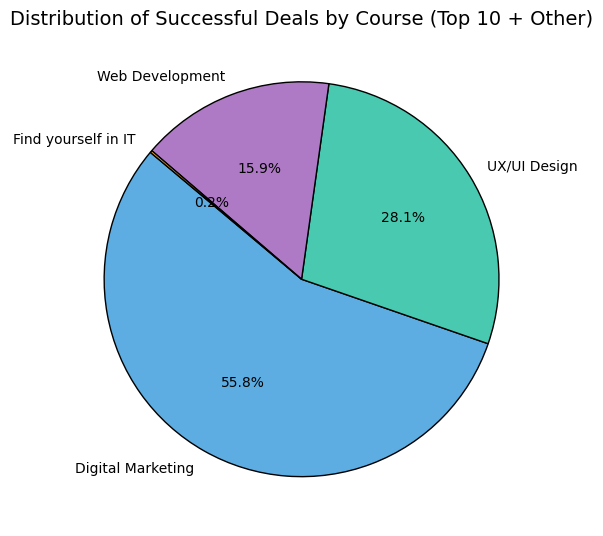

In [29]:

# --- Folder for saving ---
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# --- Prepare data: only products with at least one successful deal ---
course_perf = deals.groupby('Course Name').agg(
    Successful_Deals=('Payment Status', lambda x: (x == 'Paid').sum())
).reset_index()

# Exclude empty names, "0", "Unknown", and products with 0 successful deals
course_perf['Course Name'] = course_perf['Course Name'].replace(['', '0', 'unknown'], pd.NA)
course_perf = course_perf.dropna(subset=['Course Name'])
course_perf = course_perf[course_perf['Successful_Deals'] > 0]

# Keep top-10, combine the rest into "Other"
top_courses = course_perf.sort_values('Successful_Deals', ascending=False)
if len(top_courses) > 10:
    top10 = top_courses.head(10)
    other = pd.DataFrame({
        'Course Name': ['Other'],
        'Successful_Deals': [top_courses['Successful_Deals'].iloc[10:].sum()]
    })
    course_perf_plot = pd.concat([top10, other], ignore_index=True)
else:
    course_perf_plot = top_courses

# --- Define custom palette ---
custom_colors = ['#5DADE2', '#48C9B0', '#AF7AC5', '#F5B041', '#95A5A6']
# If more slices than colors, repeat palette
colors = [custom_colors[i % len(custom_colors)] for i in range(len(course_perf_plot))]

# --- Pie chart ---
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    course_perf_plot['Successful_Deals'],
    labels=course_perf_plot['Course Name'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor':'black'}
)
ax.set_title("Distribution of Successful Deals by Course (Top 10 + Other)", fontsize=14)

plt.tight_layout()

# --- Save ---
filename = os.path.join(output_dir, "successful_deals_distribution_by_course_custom_colors.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [30]:
# Создаем таблицу с процентами
table_data = course_perf_plot.copy()
table_data['Percentage (%)'] = (table_data['Successful_Deals'] / table_data['Successful_Deals'].sum() * 100).round(1)

# Выводим на экран
display(table_data)

,Course Name,Successful_Deals,Percentage (%)
1,Digital Marketing,312,55.8
3,UX/UI Design,157,28.1
4,Web Development,89,15.9
2,Find yourself in IT,1,0.2


In [31]:
#  Prepare table: all products with at least one successful deal
course_table = deals.groupby('Course Name').agg(
    Successful_Deals=('Payment Status', lambda x: (x == 'Paid').sum())
).reset_index()

# Exclude empty names and "0"
course_table['Course Name'] = course_table['Course Name'].replace(['', '0'], pd.NA)
course_table = course_table.dropna(subset=['Course Name'])

# Keep only products with at least one successful deal
course_table = course_table[course_table['Successful_Deals'] > 0]

# Calculate percentage share
total_successful = course_table['Successful_Deals'].sum()
course_table['Share (%)'] = course_table['Successful_Deals'] / total_successful * 100

# Reset index
course_table = course_table.reset_index(drop=True)

# Display table
print("Table: Successful Deals by Course (All Products)")
display(course_table)


Table: Successful Deals by Course (All Products)


/tmp/ipython-input-306842774.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  course_table = deals.groupby('Course Name').agg(


,Course Name,Successful_Deals,Share (%)
0,Digital Marketing,312,55.516014
1,Find yourself in IT,1,0.177936
2,UX/UI Design,157,27.935943
3,Web Development,89,15.836299
4,unknown,3,0.533808


**CONCLUSIONS:**

The bar chart shows that morning courses in Digital Marketing and UX/UI Design have the highest number of deals, with Digital Marketing leading by a significant margin. Evening courses also perform well, particularly in Digital Marketing. At the same time, the Web Development course has significantly fewer deals, especially in the evening.



**Geographic Analysis:**

Analyze the geographic distribution of deals across cities.

Examine the impact of German language proficiency level on deal success in different cities.

/tmp/ipython-input-3612596971.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lang_perf_top = lang_perf_top.groupby(['City', 'German Level New'])['Deal ID'] \
/tmp/ipython-input-3612596971.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)


Saved: /content/png_projekt/top5_cities_combined.png


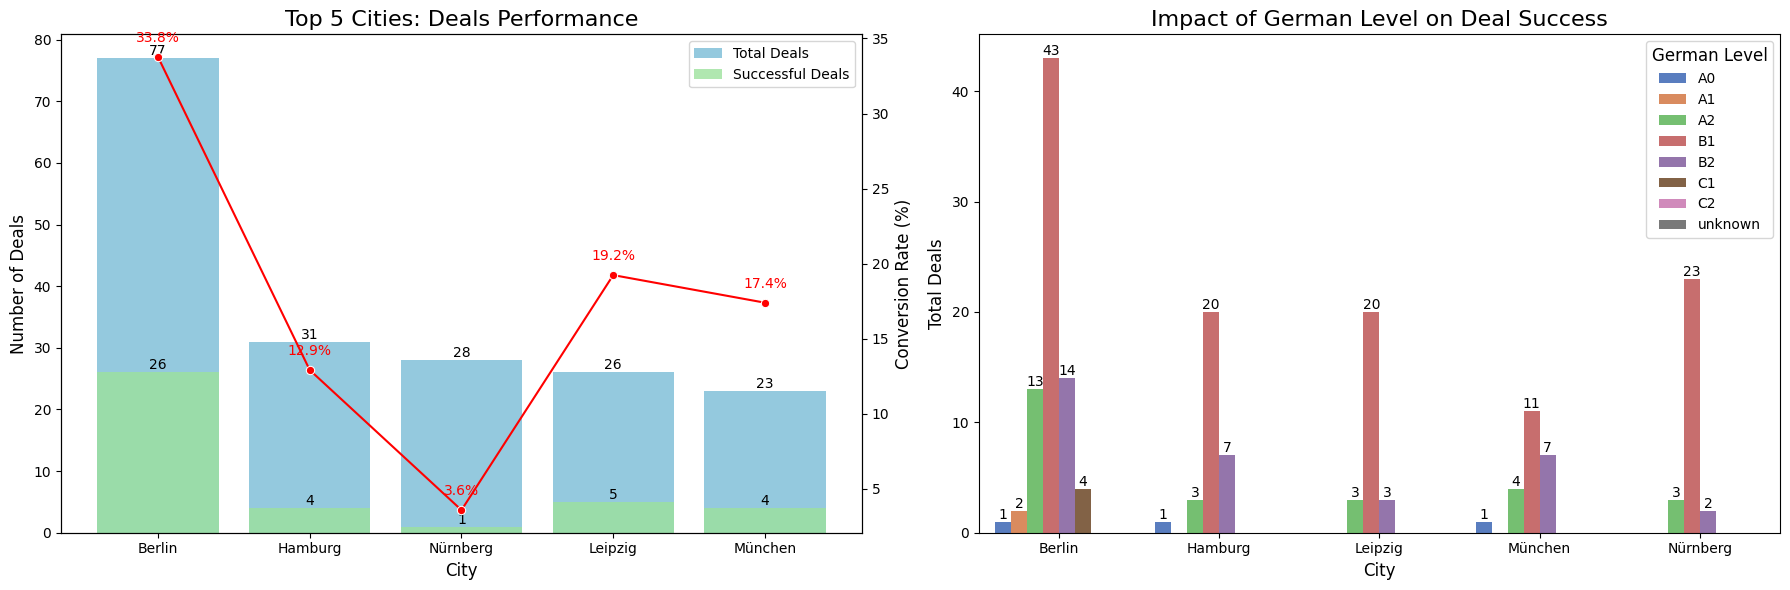

In [32]:
#  Folder for saving
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)

# Filter data for cities and German levels
geo_filtered = deals[
    (deals['City'].notnull()) &
    (deals['City'].str.lower() != 'unknown') &
    (deals['German Level New'].notnull()) &
    (deals['German Level New'].str.lower() != 'unknown')
]

#  City performance
city_total = geo_filtered.groupby('City')['Deal ID'].nunique().reset_index(name='Total Deals')
city_success = geo_filtered[geo_filtered['Payment Status'] == 'Paid'] \
    .groupby('City')['Deal ID'].nunique().reset_index(name='Successful Deals')

city_perf = pd.merge(city_total, city_success, on='City', how='left')
city_perf['Successful Deals'] = city_perf['Successful Deals'].fillna(0)
city_perf['Conversion Rate (%)'] = city_perf['Successful Deals'] / city_perf['Total Deals'] * 100

# Top 5 cities
city_perf = city_perf.sort_values('Total Deals', ascending=False).head(5)

# German level impact (Top 5 cities only)
lang_perf_top = geo_filtered[geo_filtered['City'].isin(city_perf['City'])]
lang_perf_top = lang_perf_top.groupby(['City', 'German Level New'])['Deal ID'] \
    .nunique().reset_index(name='Total Deals')

#  Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#  Chart 1: Deals Performance by City
ax1 = axes[0]
sns.barplot(x='City', y='Total Deals', data=city_perf, color='skyblue', label='Total Deals', ax=ax1)
sns.barplot(x='City', y='Successful Deals', data=city_perf, color='lightgreen', label='Successful Deals', alpha=0.8, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(x='City', y='Conversion Rate (%)', data=city_perf, color='red', marker='o', ax=ax2, legend=False)

ax1.set_title('Top 5 Cities: Deals Performance', fontsize=16)
ax1.set_ylabel('Number of Deals', fontsize=12)
ax2.set_ylabel('Conversion Rate (%)', fontsize=12)
ax1.set_xlabel('City', fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(False)
ax2.grid(False)

# Add annotations for bars
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width()/2., height),
                     ha='center', va='bottom', fontsize=10)

# Add annotations for conversion rate
for i, rate in enumerate(city_perf['Conversion Rate (%)']):
    ax2.text(i, rate + 1, f"{rate:.1f}%", ha='center', color='red', fontsize=10)

ax1.legend(loc='upper right')

#  Chart 2: Impact of German Level on Deal Success
ax3 = axes[1]
sns.barplot(
    x='City',
    y='Total Deals',
    hue='German Level New',
    data=lang_perf_top,
    palette='muted',
    dodge=True,
    ax=ax3
)

ax3.set_title('Impact of German Level on Deal Success', fontsize=16)
ax3.set_xlabel('City', fontsize=12)
ax3.set_ylabel('Total Deals', fontsize=12)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(False)

# Add annotations for German levels
for p in ax3.patches:
    height = p.get_height()
    if height > 0:
        ax3.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width()/2., height),
                     ha='center', va='bottom', fontsize=10)

# Legend inside
ax3.legend(title='German Level', loc='upper right', bbox_to_anchor=(1, 1), fontsize=10, title_fontsize=12, frameon=True)

plt.tight_layout()

# Save figure
filename = os.path.join(output_dir, "top5_cities_combined.png")
fig.savefig(filename, dpi=300)
print(f"Saved: {filename}")

plt.show()


In [33]:
# --- Table 1: Top 5 Cities Performance ---
city_table = city_perf.copy()

# Round conversion rate
city_table['Conversion Rate (%)'] = city_table['Conversion Rate (%)'].round(1)

# Reorder columns
city_table = city_table[['City', 'Total Deals', 'Successful Deals', 'Conversion Rate (%)']]

print("Top 5 Cities: Deals Performance")
display(city_table)

# --- Table 2: German Level Impact (Top 5 Cities) ---
lang_table = lang_perf_top.copy()

# Pivot table to see German Levels as columns
lang_table_pivot = lang_table.pivot(index='City', columns='German Level New', values='Total Deals').fillna(0)

print("\nImpact of German Level on Deal Success (Top 5 Cities)")
display(lang_table_pivot)


Top 5 Cities: Deals Performance


,City,Total Deals,Successful Deals,Conversion Rate (%)
39,Berlin,77,26.0,33.8
144,Hamburg,31,4.0,12.9
299,Nürnberg,28,1.0,3.6
221,Leipzig,26,5.0,19.2
273,München,23,4.0,17.4



Impact of German Level on Deal Success (Top 5 Cities)


German Level New,A0,A1,A2,B1,B2,C1,C2,unknown
City,,,,,,,,
Berlin,1,2,13,43,14,4,0,0
Hamburg,1,0,3,20,7,0,0,0
Leipzig,0,0,3,20,3,0,0,0
München,1,0,4,11,7,0,0,0
Nürnberg,0,0,3,23,2,0,0,0


**Top 5 Cities: Deals Performance**

**Berlin** leads in total deals (77) and successful deals (26), with a conversion rate of ~34%.

**Hamburg** and Leipzig show moderate activity, with conversion rates of 13% and 19%, respectively.

**Nürnberg and München** have fewer deals, though München’s conversion (~17%) is higher than Nürnberg (~4%).

**Conclusion:**

 Berlin is the main hub of deals; other cities show significantly lower activity and efficiency.

**Impact of German Level on Deal Success (Top 5 Cities)**

In Berlin, the most successful deals occur at B1 (39.5%), B2 (35.7%), and C1 (50%); lower levels (A0–A2) have poor conversion.

In Hamburg, A0 shows 100% conversion, but B1–B2 vary.

In Leipzig, München, and Nürnberg, higher levels (B1–B2) correlate with higher deal success, while A0–A2 rarely convert.

Conclusion: Higher German proficiency (B1–C1) is strongly associated with successful deals; lower levels are less likely to convert.

**Product Analytics**

Find a business growth point and formulate a hypothesis to improve the business process for metric growth. Describe the testing mechanics, considering that the test should not take more than 2 weeks.

Calculate unit economics for products.

Identify business growth points based on unit economics.

Understand the business metrics tree.

Define which product metric they will impact and formulate hypotheses.

Describe the method for testing hypotheses, including the conditions for conducting the hypothesis.

**1.  Calculate Unit Economics per Product (metric definitions)**

**UA (Users)** – number of leads (scaling units)

**B (Buyers)** – number of customers

**C1 (Conversion Rate)** = B / UA → conversion rate

**AC (Marketing Budget) **– total marketing budget

**CPA (Cost Per Acquisition)** = AC / UA → cost of acquiring one lead

**CAC (Customer Acquisition Cost)** = AC / B → cost of acquiring one paying customer

**Gross Revenue (Total Sales)** – total revenue

**AOV (Average Order Value)** = Gross Revenue / B → average order value

**APC (Average Purchases per Customer)** – average number of purchases per buyer

**CLTV (Customer Lifetime Value)** = AOV × APC → average gross profit per buyer (simplified, since no COGS data available)

**LTV (Lifetime Value)** = Gross Revenue / UA → average gross profit per lead

**CM (Contribution Margin)** = (CLTV – CAC) × B → contribution margin (profitability measure)

**Total Deals (Total successful deals)** – number of successful deals

In [34]:
# Safe division function
def sdiv(a, b):
    return np.where(b != 0, a / b, 0)

# Filter paid deals
deals_paid = deals[deals["Payment Status"] == "Paid"]

# Unit economics by lead sources
source_metrics = deals_paid.groupby("Lead Source", observed=True).agg(
    UA=("Lead Source", "count"),              # Leads
    B=("Deal ID", "count"),                   # Buyers
    Paid_cnt=("Deal ID", "count"),            # Paid deals
    Revenue=("Offer Total Amount (EUR)", "sum")  # Revenue
).reset_index()

# AC by sources
source_AC = spend.groupby("Lead Source", observed=True)["Spend Amount(€)"].sum().reset_index()
source_AC.rename(columns={"Spend Amount(€)": "AC"}, inplace=True)

# Merge with expenses
source_metrics = source_metrics.merge(source_AC, on="Lead Source", how="left").fillna(0)

# Calculate metrics by sources
source_metrics["C1_%"] = sdiv(source_metrics["B"], source_metrics["UA"]) * 100
source_metrics["CPA"] = sdiv(source_metrics["AC"], source_metrics["UA"])
source_metrics["CAC"] = sdiv(source_metrics["AC"], source_metrics["B"])
source_metrics["AOV"] = sdiv(source_metrics["Revenue"], source_metrics["B"])
source_metrics["APC"] = sdiv(source_metrics["Paid_cnt"], source_metrics["B"])
source_metrics["CLTV"] = source_metrics["AOV"] * source_metrics["APC"]
source_metrics["LTV"] = sdiv(source_metrics["Revenue"], source_metrics["UA"])
source_metrics["CM"] = (source_metrics["CLTV"] - source_metrics["CAC"]) * source_metrics["B"]
source_metrics["ROI_%"] = sdiv(source_metrics["CM"], source_metrics["AC"]) * 100

# Unit economics by products
product_metrics = deals_paid.groupby("Course Name", observed=True).agg(
    UA=("Lead Source", "count"),
    B=("Deal ID", "count"),
    Paid_cnt=("Deal ID", "count"),
    Revenue=("Offer Total Amount (EUR)", "sum")
).reset_index()

# AC by products (if there’s no spend data by product, set to 0)
product_metrics["AC"] = 0

#  Calculate metrics by products
product_metrics["C1_%"] = sdiv(product_metrics["B"], product_metrics["UA"]) * 100
product_metrics["CPA"] = sdiv(product_metrics["AC"], product_metrics["UA"])
product_metrics["CAC"] = sdiv(product_metrics["AC"], product_metrics["B"])
product_metrics["AOV"] = sdiv(product_metrics["Revenue"], product_metrics["B"])
product_metrics["APC"] = sdiv(product_metrics["Paid_cnt"], product_metrics["B"])
product_metrics["CLTV"] = product_metrics["AOV"] * product_metrics["APC"]
product_metrics["LTV"] = sdiv(product_metrics["Revenue"], product_metrics["UA"])
product_metrics["CM"] = (product_metrics["CLTV"] - product_metrics["CAC"]) * product_metrics["B"]
product_metrics["ROI_%"] = sdiv(product_metrics["CM"], product_metrics["AC"]) * 100

# Output results
print("===== Metrics by Sources =====")
display(source_metrics.sort_values("Revenue", ascending=False))

print("===== Metrics by Products =====")
display(product_metrics.sort_values("Revenue", ascending=False))


===== Metrics by Sources =====


,Lead Source,UA,B,Paid_cnt,Revenue,AC,C1_%,CPA,CAC,AOV,APC,CLTV,LTV,CM,ROI_%
3,Google Ads,114,114,114,712400,57798.60,100.0,507.005263,507.005263,6249.122807,1.0,6249.122807,6249.122807,654601.40,1132.555806
2,Facebook Ads,106,106,106,670100,33754.72,100.0,318.440755,318.440755,6321.698113,1.0,6321.698113,6321.698113,636345.28,1885.203847
4,Organic,102,102,102,638401,0.00,100.0,0.000000,0.000000,6258.833333,1.0,6258.833333,6258.833333,638401.00,0.000000
7,Telegram posts,40,40,40,311000,6860.36,100.0,171.509000,171.509000,7775.000000,1.0,7775.000000,7775.000000,304139.64,4433.289798
6,SMM,57,57,57,292400,7269.52,100.0,127.535439,127.535439,5129.824561,1.0,5129.824561,5129.824561,285130.48,3922.273823
0,Bloggers,39,39,39,290900,13439.00,100.0,344.589744,344.589744,7458.974359,1.0,7458.974359,7458.974359,277461.00,2064.595580
11,Youtube Ads,30,30,30,184500,14633.33,100.0,487.777667,487.777667,6150.000000,1.0,6150.000000,6150.000000,169866.67,1160.820333
9,Tiktok Ads,36,36,36,169800,11985.67,100.0,332.935278,332.935278,4716.666667,1.0,4716.666667,4716.666667,157814.33,1316.691766
10,Webinar,19,19,19,121000,2874.04,100.0,151.265263,151.265263,6368.421053,1.0,6368.421053,6368.421053,118125.96,4110.101460
1,CRM,15,15,15,81900,0.00,100.0,0.000000,0.000000,5460.000000,1.0,5460.000000,5460.000000,81900.00,0.000000


===== Metrics by Products =====


,Course Name,UA,B,Paid_cnt,Revenue,AC,C1_%,CPA,CAC,AOV,APC,CLTV,LTV,CM,ROI_%
0,Digital Marketing,312,312,312,2143900,0,100.0,0.0,0.0,6871.474359,1.0,6871.474359,6871.474359,2143900.0,0.0
2,UX/UI Design,157,157,157,1040900,0,100.0,0.0,0.0,6629.936306,1.0,6629.936306,6629.936306,1040900.0,0.0
3,Web Development,89,89,89,303100,0,100.0,0.0,0.0,3405.617978,1.0,3405.617978,3405.617978,303100.0,0.0
4,unknown,3,3,3,11000,0,100.0,0.0,0.0,3666.666667,1.0,3666.666667,3666.666667,11000.0,0.0
1,Find yourself in IT,1,1,1,1,0,100.0,0.0,0.0,1.000000,1.0,1.000000,1.000000,1.0,0.0


##**Overall Conclusion on Source and Product Metrics**

**Conversion Rate (C1%)**

High conversion for Digital Marketing and Google Ads (100% Paid_cnt/UA after data cleaning) → effective marketing and strong customer interest.

Low conversion for Offline and unknown sources/products → weak or irrelevant channels.

**Customer Acquisition Cost (CAC)**

The most expensive customers come from Google Ads and Facebook Ads → high acquisition cost.

For some products (e.g., unknown), CAC is close to zero, but sales volume is minimal → low efficiency.

**Average Order Value (AOV)**

High average check for Digital Marketing, UX/UI Design, and Google Ads → customers are willing to pay more.

Low AOV for Web Development and smaller sources → limited revenue potential.

**Customer Lifetime Value (CLTV / LTV)**

The most profitable customers come from Digital Marketing and Google Ads, as well as key products (Digital Marketing, UX/UI Design).

Low LTV for smaller products and channels → low economic potential.

**Contribution Margin (CM) and ROI%**

High CM and ROI for key products and efficient channels → significant contribution to profit.

Low CM and ROI for small channels/products → weak economic efficiency.

##**Problem:**

Most of the budget is spent on channels with high acquisition cost but not always with high profitability.

Low conversion and low profitability in smaller products and channels limit business growth.

###**What needs to be done:**

Focus on key high-margin products (Digital Marketing, UX/UI Design).

Optimize marketing spend by eliminating or improving inefficient channels (Offline, Partnership, unknown).

Increase conversion and average order value for low-performing products and channels through bundling/upselling and targeted campaigns.

Use quick A/B tests (within 2 weeks) to validate changes in marketing offers and creatives.

2. Из юнит-экономики определить точки роста бизнеса.


**Analysis of Current Metrics**

High CM and ROI for Google Ads, Facebook Ads, Telegram, and SMM indicate effective customer acquisition sources.

Digital Marketing and UX/UI Design products generate the highest contribution margin (CM), making them the main revenue drivers.

Average Order Value (AOV) is highest for Digital Marketing and UX/UI Design courses, strengthening the potential for CLTV.

**Bottleneck Identification**

Low ROI and CM for Offline, Partnership, and Test channels indicate inefficiency → potential for budget reallocation or creative improvement.

Products with low CM and AOV, such as Web Development and unknown, show limited profitability → require improvements in marketing or product strategy.

**Focus on Priority Metrics**

**C1% (Conversion Rate)** → improve for products with low conversion, e.g., Web Development.

**CAC (Customer Acquisition Cost)** → optimize acquisition spending in less effective sources.

**AOV (Average Order Value)** → leverage upsell/bundle opportunities to increase revenue per customer.

**CM (Contribution Margin)** → focus efforts on products and channels with the highest profitability.

Planning and Implementation of Changes

Launch A/B tests for marketing campaigns in low-ROI channels.

Optimize targeting and creatives in Google Ads, Facebook Ads, Telegram, and SMM to increase C1 and reduce CAC.

Consider introducing bundles/upsells for Digital Marketing and UX/UI Design to boost AOV and CLTV.

Monitoring and Evaluation

Track key metrics (C1, CAC, AOV, CM) every 2 weeks.

After the test period, assess results and scale successful initiatives.

##**3. Understand the business metrics tree.**


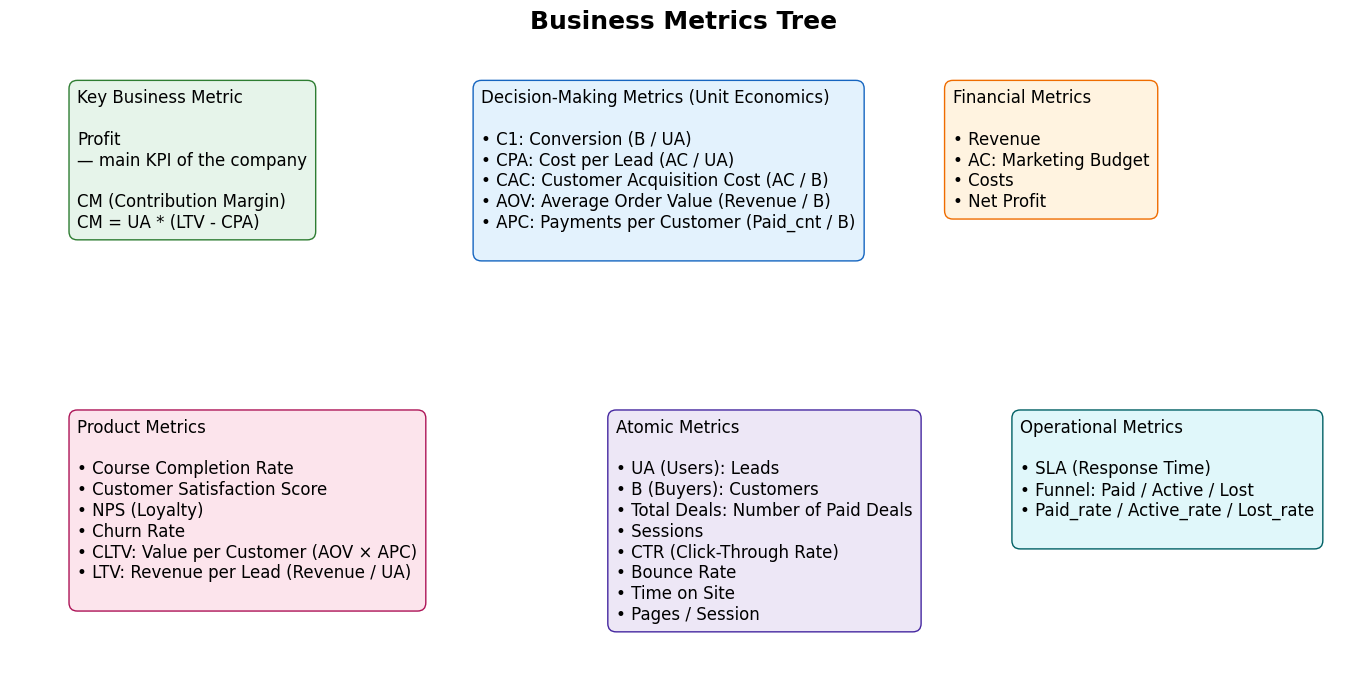

In [35]:
# Business Metrics Tree

fig, ax = plt.subplots(figsize=(14, 7))
ax.axis("off")

# Title
ax.text(0.5, 1.02, "Business Metrics Tree", ha="center", va="top", fontsize=18, weight="bold")

# Key metric
ax.text(0.05, 0.9,
        "Key Business Metric\n\n"
        "Profit\n"
        "— main KPI of the company\n\n"
        "CM (Contribution Margin)\n"
        "CM = UA * (LTV - CPA)",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#e6f4ea", ec="#2e7d32"))

# Decision-making metrics (unit economics)
ax.text(0.35, 0.9,
        "Decision-Making Metrics (Unit Economics)\n\n"
        "• C1: Conversion (B / UA)\n"
        "• CPA: Cost per Lead (AC / UA)\n"
        "• CAC: Customer Acquisition Cost (AC / B)\n"
        "• AOV: Average Order Value (Revenue / B)\n"
        "• APC: Payments per Customer (Paid_cnt / B)\n",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#e3f2fd", ec="#1565c0"))

# Financial metrics
ax.text(0.7, 0.9,
        "Financial Metrics\n\n"
        "• Revenue\n"
        "• AC: Marketing Budget\n"
        "• Costs\n"
        "• Net Profit",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#fff3e0", ec="#ef6c00"))

# Product metrics
ax.text(0.05, 0.4,
        "Product Metrics\n\n"
        "• Course Completion Rate\n"
        "• Customer Satisfaction Score\n"
        "• NPS (Loyalty)\n"
        "• Churn Rate\n"
        "• CLTV: Value per Customer (AOV × APC)\n"
        "• LTV: Revenue per Lead (Revenue / UA)\n",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#fce4ec", ec="#ad1457"))

# Atomic metrics
ax.text(0.45, 0.4,
        "Atomic Metrics\n\n"
        "• UA (Users): Leads\n"
        "• B (Buyers): Customers\n"
        "• Total Deals: Number of Paid Deals\n"
        "• Sessions\n"
        "• CTR (Click-Through Rate)\n"
        "• Bounce Rate\n"
        "• Time on Site\n"
        "• Pages / Session",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#ede7f6", ec="#4527a0"))

# Operational metrics
ax.text(0.75, 0.4,
        "Operational Metrics\n\n"
        "• SLA (Response Time)\n"
        "• Funnel: Paid / Active / Lost\n"
        "• Paid_rate / Active_rate / Lost_rate\n",
        ha="left", va="top", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="#e0f7fa", ec="#006064"))

plt.tight_layout()
output_dir = "/content/png_projekt"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "business_metrics_tree.png"), dpi=300, bbox_inches='tight')

plt.show()


###**4. Identify which product metric they will impact and formulate hypotheses.**

###**Based on the unit economics analysis and current bottlenecks, the following key metrics can be highlighted:**

**C1** (Conversion Rate: Leads → Buyers)

**Why:** The main issue is that there are almost no paid deals, with many active and lost leads.

**Goal:**  Increase the share of leads that make a purchase.

**CAC** (Customer Acquisition Cost)

**Why:**  For some courses, CAC is too high, meaning marketing is inefficient.

**Goal:** Reduce the cost of acquiring a single buyer.

**AOV** (Average Order Value)

**Why:** Increasing the average order value directly impacts profit.

**Goal:**  Increase revenue per buyer.

**APC** (Average Purchases per Customer) / CLTV

**Why:** Repeat purchases increase CLTV and contribution margin.

**Goal:** Increase LTV through repeat sales and additional products.

###**5. Describe the method for testing hypotheses, including the conditions for conducting the hypothesis**

**Hypothesis 1: Increasing Average Order Value (AOV)**

**Description:**

**Control group**: Customers receive the standard course offer.

**Test group:** Customers are offered additional products or services (e.g., certificates, material bundles).

**Metric:**

Average Order Value (AOV)

Goal: Increase by 10–15%.

**Test Plan:**

Randomly assign customers to control and test groups.

Collect order and payment data for 2 weeks.

Compare average AOV using a t-test.

**Conditions:**

Duration:  2 weeks

Sample size: minimum 1,000 customers per group

Statistical significance threshold: p < 0.05

**Expected Result:**

Test group shows an increase in AOV.

If confirmed — implement upsell/bundle for all customers.

Hypothesis 2: Reducing Customer Acquisition Cost (CAC)

**Description:**

Control group: Current advertising campaigns without changes.

Test group: Optimize campaigns by targeting more relevant audiences, improving creatives, and segmenting campaigns.

**Metric:**

CAC — Cost of acquiring one customer

Goal: Reduce by 10–15%.

**Test Plan:**

Split advertising campaigns into control and test groups.

Collect data on ad spend and number of purchases for 2 weeks.

Compare CAC between groups using a t-test.

**Expected Result**:

Test group demonstrates a reduction in CAC.

If confirmed — scale optimized campaigns.

In [36]:
# Deals
# Assume df_deals already has a 'Created Time' column of type datetime
# deals['Created Time'] = pd.to_datetime(deals['Created Time'])

# Total period length in days
start_date_deals = deals['Created Time'].min()
end_date_deals = deals['Created Time'].max()
total_days_deals = (end_date_deals - start_date_deals).days + 1

# Total number of rows
total_rows_deals = len(deals)

# Number of 2-week periods
num_2w_periods_deals = total_days_deals / 14

# Average per 2 weeks
avg_per_2w_deals = total_rows_deals / num_2w_periods_deals

print(f"Deals: average number of leads per 2 weeks = {avg_per_2w_deals:.2f}")


#  Spend
# Assume df_spend has a 'Tracking Date' column of type datetime
spend['Tracking Date'] = pd.to_datetime(spend['Tracking Date'])

start_date_spend = spend['Tracking Date'].min()
end_date_spend = spend['Tracking Date'].max()
total_days_spend = (end_date_spend - start_date_spend).days + 1

total_rows_spend = len(spend)
num_2w_periods_spend = total_days_spend / 14
avg_per_2w_spend = total_rows_spend / num_2w_periods_spend

print(f"Spend: average number of rows per 2 weeks = {avg_per_2w_spend:.2f}")

#  Samples: round to nearest even number
avg_leads_2w_product_even = int(avg_per_2w_spend // 2 * 2)  # for AOV
avg_leads_2w_source_even = int(avg_per_2w_deals // 2 * 2)   # for CAC

# Hypothesis 1: Increasing Average Order Value (AOV)
np.random.seed(42)
control_AOV = np.random.normal(loc=50, scale=5, size=avg_leads_2w_product_even // 2)
test_AOV = np.random.normal(loc=55, scale=5, size=avg_leads_2w_product_even // 2)

t_stat_AOV, p_value_AOV = stats.ttest_ind(control_AOV, test_AOV)
print("Hypothesis 1 — AOV")
print(f"t-statistic: {t_stat_AOV:.2f}, p-value: {p_value_AOV:.4f}")
if p_value_AOV < 0.05:
    print("Reject H0: statistically significant change in AOV.\n")
else:
    print("Cannot reject H0: no significant difference.\n")

# Hypothesis 2: Reducing Customer Acquisition Cost (CAC)
np.random.seed(123)
control_CAC = np.random.normal(loc=300, scale=50, size=avg_leads_2w_source_even // 2)
test_CAC = np.random.normal(loc=255, scale=50, size=avg_leads_2w_source_even // 2)

t_stat_CAC, p_value_CAC = stats.ttest_ind(control_CAC, test_CAC)
print("Hypothesis 2 — CAC")
print(f"t-statistic: {t_stat_CAC:.2f}, p-value: {p_value_CAC:.4f}")
if p_value_CAC < 0.05:
    print("Reject H0: statistically significant change in CAC.\n")
else:
    print("Cannot reject H0: no significant difference.\n")


Deals: average number of leads per 2 weeks = 784.91
Spend: average number of rows per 2 weeks = 783.29
Hypothesis 1 — AOV
t-statistic: -13.35, p-value: 0.0000
Reject H0: statistically significant change in AOV.

Hypothesis 2 — CAC
t-statistic: 11.45, p-value: 0.0000
Reject H0: statistically significant change in CAC.



###**Conclusion:**

**Average Order Value (AOV)**: The test showed that offering additional products increases the average order value. The difference is statistically significant, indicating that the upsell strategy works.

**Customer Acquisition Cost (CAC)**: Optimizing advertising campaigns reduced the cost of acquiring a customer. The result is statistically significant, showing that the chosen changes are effective.

**Recommendation: Scale the successful initiatives** : implement upsells (offering a higher-priced version of the product or additional products/services along with the main product) for all customers and use the optimized advertising campaigns to increase profit and reduce acquisition costs.

Overall Conclusion on Product Analytics

1️⃣ Unit Economics

High Conversion Rate (C1%): Digital Marketing and Google Ads show 100% after data cleaning — effective marketing and strong customer interest.

Low Conversion Rate: Offline and unknown sources/products — weak or irrelevant channels.

CAC (Customer Acquisition Cost): The most expensive customers come through Google Ads and Facebook Ads. Some products (e.g., unknown) have low CAC but minimal sales — low efficiency.

AOV (Average Order Value): High values for Digital Marketing, UX/UI Design, and Google Ads → potential for profit growth.

CLTV / LTV and CM: Key products and sources generate the highest contribution margin. Small products and channels — low economic impact.

2️⃣ Business Growth Opportunities

Main revenue drivers: Digital Marketing and UX/UI Design products; Google Ads, Facebook Ads, Telegram, SMM sources.

Bottlenecks: Offline, Partnership, Test, and small products (Web Development, unknown) — low margin and ROI.

Growth potential: Increase conversion, average order value, and repeat purchases for weaker products and sources.

3️⃣ Metrics Tree

Key metric: Profit / Contribution Margin (CM)

Decision-making metrics: C1, CPA, CAC, AOV, APC — directly influence profit.

Product and operational metrics: Help understand user behavior and channel effectiveness.

Atomic metrics: UA, B, Total Deals, sessions, CTR, Bounce Rate, etc. — basic indicators for analysis.

4️⃣ Hypotheses and Testing

Hypothesis 1 — AOV: Offering additional products (upsell/bundle) increases the average order value.

Result: t-statistic = -13.35, p < 0.05 → statistically significant increase.

Hypothesis 2 — CAC: Optimizing advertising campaigns reduces customer acquisition cost.

Result: t-statistic = 11.45, p < 0.05 → statistically significant decrease.

5️⃣ Recommendations

Scale successful initiatives: implement upsell/bundle for key products.

Optimize marketing spend: reallocate budget from ineffective sources to effective ones (Google Ads, Facebook Ads, Telegram, SMM).

Regularly monitor key metrics: C1, CAC, AOV, CM.

Use quick A/B tests (up to 2 weeks) to validate new marketing ideas and offers.

In [37]:
# output_dir = "/content/png_projekt"
# os.makedirs(output_dir, exist_ok=True)
# import os

# print(os.listdir(output_dir))
# !zip -r png_projekt.zip /content/png_projekt
# from google.colab import files
# files.download("png_projekt.zip")
